In [234]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
import Categorization
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
from PIL import Image
import os



In [51]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

PatientID  Mortality14Days  ALT  AST  Admit Ht  Albumin  \
0         178177                0  NaN  NaN       NaN      NaN   
1         178177                0  NaN  NaN       NaN      NaN   
2         178177                0  NaN  NaN       NaN      NaN   
3         178177                0  NaN  NaN       NaN      NaN   
4         178177                0  NaN  NaN       NaN      NaN   
...          ...              ...  ...  ...       ...      ...   
47083     159740                0  NaN  NaN       NaN      NaN   
47084     159740                0  NaN  NaN       NaN      NaN   
47085     159740                0  NaN  NaN       NaN      NaN   
47086     159740                0  NaN  NaN       NaN      NaN   
47087     159740                0  NaN  NaN       NaN      NaN   

       Arterial BP Mean  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
0                   NaN                      NaN                     NaN   
1                   NaN                      NaN                     NaN   
2                   NaN                      NaN                     NaN   
3                   NaN                      NaN                     NaN   
4                   NaN                      NaN                     NaN   
...                 ...                      ...                     ...   
47083               NaN                      NaN                     NaN   
47084               NaN                      NaN                     NaN   
47085               NaN                      NaN                     NaN   
47086               NaN                      NaN                     NaN   
47087               NaN                      NaN                     NaN   

       Arterial PaCO2  ...  SVI  SVR  SVRI  SaO2  Sodium  SpO2  SvO2  \
0                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
1                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
2                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
3                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
4                 NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
...               ...  ...  ...  ...   ...   ...     ...   ...   ...   
47083             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47084             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47085             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47086             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   
47087             NaN  ...  NaN  NaN   NaN   NaN     NaN   NaN   NaN   

       Temperature C  Total Bili  WBC  
0                NaN         NaN  NaN  
1                NaN         NaN  NaN  
2                NaN         NaN  NaN  
3                NaN         NaN  NaN  
4                NaN         NaN  NaN  
...              ...         ...  ...  
47083            NaN         NaN  NaN  
47084            NaN         NaN  NaN  
47085            NaN         NaN  NaN  
47086            NaN         NaN  NaN  
47087            NaN         NaN  NaN  

[47088 rows x 44 columns]

In [52]:
mimicDF[mimicDF['Arterial pH'] > 8]

PatientID  Mortality14Days  ALT  AST  Admit Ht  Albumin  \
36229     198163                0  NaN  NaN       NaN      NaN   

       Arterial BP Mean  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
36229              87.0                     76.0                   120.0   

       Arterial PaCO2  ...  SVI  SVR  SVRI  SaO2  Sodium   SpO2  SvO2  \
36229            29.0  ...  NaN  NaN   NaN   NaN     NaN  100.0   NaN   

       Temperature C  Total Bili  WBC  
36229      37.900002         NaN  NaN  

[1 rows x 44 columns]

In [53]:
# Too many columns to display all in one cell.

step = 10

for idx in range(0, len(mimicDF.columns), step):
    tempCols = mimicDF.columns[idx:idx+step]
    display(mimicDF[tempCols].describe())

PatientID  Mortality14Days          ALT           AST    Admit Ht  \
count   47088.000000     47088.000000   484.000000    481.000000  705.000000   
mean   151079.910805         0.039755   630.123967    954.301455   67.382553   
std     29378.613191         0.195386  1245.805613   2384.326867    5.448469   
min    100059.000000         0.000000     3.000000      3.000000   48.000000   
25%    126241.000000         0.000000    25.000000     49.000000   64.000000   
50%    151857.000000         0.000000    97.000000    137.000000   68.000000   
75%    176484.000000         0.000000   554.750000    797.000000   70.000000   
max    199998.000000         1.000000  8100.000000  23060.000000  160.000000   

          Albumin  Arterial BP Mean  Arterial BP [Diastolic]  \
count  245.000000      31415.000000             31503.000000   
mean     2.721633         77.058157                57.226709   
std      0.584693         14.324177                11.197415   
min      1.400000          0.000000                 0.000000   
25%      2.400000         68.000000                50.000000   
50%      2.700000         75.000000                56.000000   
75%      3.000000         84.000000                63.000000   
max      4.400000        287.000000               191.000000   

       Arterial BP [Systolic]  Arterial PaCO2  
count            31504.000000     8601.000000  
mean               117.544502       40.565399  
std                 21.311674        7.078312  
min                  0.000000       15.000000  
25%                103.000000       36.000000  
50%                115.000000       40.000000  
75%                129.000000       44.000000  
max                255.000000       91.000000

Arterial PaO2  Arterial pH          BUN           CVP         CaO2  \
count    8582.000000  9143.000000  1978.000000  27657.000000  3667.000000   
mean      152.720982     7.400322    24.094034     11.796478    13.867385   
std        92.767596     1.879658    14.906156      5.155437     1.898516   
min         7.470000     6.920000     3.000000      0.000000     0.706800   
25%        90.000000     7.340000    14.000000      8.000000    12.651100   
50%       118.000000     7.380000    20.000000     11.000000    13.784700   
75%       174.750000     7.420000    31.000000     15.000000    14.918100   
max       499.000000   187.000000   143.000000     50.000000    22.196800   

          Chloride   Creatinine  Daily Weight  Fibrinogen      Glucose  
count  1741.000000  1982.000000    956.000000  572.000000  7978.000000  
mean    107.547961     1.475732     91.145711  248.688986   125.757458  
std       4.878126     1.330165     22.804774  123.542862    40.834841  
min      87.000000     0.200000      0.000000   68.000000    26.000000  
25%     105.000000     0.800000     75.500000  166.750000   101.000000  
50%     108.000000     1.100000     88.650002  213.500000   119.000000  
75%     111.000000     1.500000    104.099998  301.250000   142.000000  
max     133.000000    12.500000    208.199997  925.000000   638.000000

Heart Rate   Hemoglobin          INR  Ionized Calcium           LDH  \
count  34081.000000  3487.000000  1909.000000      6518.000000    215.000000   
mean      86.659987    10.381594     1.459246         1.247281   1209.302326   
std       14.619726     1.536069     0.857355         3.527599   1870.129434   
min        0.000000     0.000000     0.600000         0.490000    152.000000   
25%       78.000000     9.400000     1.200000         1.090000    318.500000   
50%       86.000000    10.300000     1.300000         1.150000    439.000000   
75%       95.000000    11.200000     1.500000         1.200000   1037.000000   
max      223.000000    19.100000    27.000000       160.000000  12240.000000   

         Magnesium     NBP Mean  NBP [Diastolic]  NBP [Systolic]          PTT  
count  1881.000000  5404.000000      5451.000000     5473.000000  1937.000000  
mean      2.138437    73.803848        54.465603      114.147040    41.343211  
std       0.417471    13.540250        13.884506       21.738575    20.785616  
min       0.800000     0.000000         0.000000        0.000000    21.300000  
25%       1.900000    64.666702        45.000000      100.000000    30.400000  
50%       2.100000    72.333298        53.000000      112.000000    35.400000  
75%       2.300000    81.333298        63.000000      126.000000    43.600000  
max       4.500000   149.000000       125.000000      234.000000   150.000000

Platelets     Potassium  Resp Rate (Spont)  \
count  3222.000000   5717.000000        4043.000000   
mean    142.337678     15.009138           2.345041   
std      65.006060    810.131474           4.719276   
min      18.000000      2.300000           0.000000   
25%      97.000000      3.900000           0.000000   
50%     131.000000      4.200000           0.000000   
75%     174.000000      4.600000           3.000000   
max     689.000000  61259.000000          38.000000   

       Respiratory Rate (spontaneous)           SVI           SVR  \
count                             1.0  12981.000000  14768.000000   
mean                              5.0     33.217492    987.290546   
std                               NaN     10.474703    363.504762   
min                               5.0      0.000000      0.000000   
25%                               5.0     26.168200    737.500000   
50%                               5.0     31.460699    931.028503   
75%                               5.0     38.118801   1169.229980   
max                               5.0    179.212997   3784.620117   

               SVRI         SaO2       Sodium          SpO2  
count  14714.000000  4352.000000  2485.000000  32961.000000  
mean    1917.421073    96.799012   138.022942     97.267665  
std      608.801780     2.659592     5.435978      3.083466  
min        0.000000    42.000000     1.210000      0.000000  
25%     1494.877533    96.000000   136.000000     96.000000  
50%     1841.049988    97.000000   138.000000     98.000000  
75%     2244.340088    98.000000   140.000000    100.000000  
max     6000.000000   100.000000   164.000000    100.000000

SvO2  Temperature C  Total Bili          WBC
count   85.000000   26516.000000  331.000000  2118.000000
mean    64.988235      37.235334    2.529305    12.747691
std     10.518118       1.399548    3.004787     5.523420
min     43.000000       0.000000    0.000000     1.900000
25%     58.000000      36.900002    0.600000     9.000000
50%     65.000000      37.299999    1.400000    11.900000
75%     71.000000      37.700001    3.300000    15.500000
max    100.000000      46.500000   16.400000    48.300000

In [54]:
# Fixing 'arterial pH', 'ionized calcium' since they contain erroneous values.

mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()

C:\Users\benma\AppData\Local\Temp/ipykernel_5528/153206369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
C:\Users\benma\AppData\Local\Temp/ipykernel_5528/153206369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()


In [55]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [56]:
patients = th.get_patients(mimicDF)

print(len(patients))

1126


In [57]:
totalNullColumns = 0

for patient in patients:
    totalNullColumns += patient.data.isnull().all().sum()

totalColumns = len(patient.data.columns) * len(patients)

print(totalColumns, totalNullColumns)

print(f"{np.round(totalNullColumns / totalColumns * 100, 2)}% of columns are null")

47292 15553
32.89% of columns are null


Counting how many columns have no data in 

100%|██████████| 39/39 [00:01<00:00, 20.06it/s]


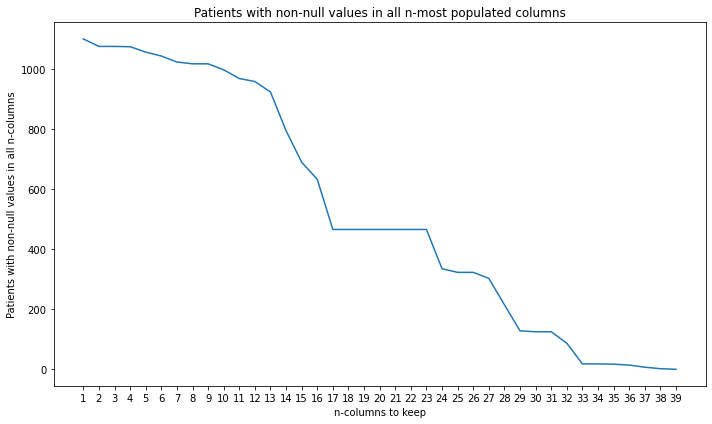

In [58]:
patientsKept, columnsExplored = th.count_null(patients)

#### Sharp drop off after 12 columns so will keep around 1000 patients with at least some data in the top 12 columns

In [59]:
clusteringPatients = th.get_top_columns(patients, 12)

print(len(clusteringPatients))

clusteringPatients[0].topColumns

959


Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
0         NaN                      NaN                     NaN   
1         NaN                      NaN                     NaN   
2         NaN                      NaN                     NaN   
3         NaN                      NaN                     NaN   
4         NaN                      NaN                     NaN   
5         NaN                      NaN                     NaN   
6         NaN                      NaN                     NaN   
7         NaN                      NaN                     NaN   
8         NaN                      NaN                     NaN   
9         NaN                      NaN                     NaN   
10        NaN                      NaN                     NaN   
11        NaN                      NaN                     NaN   
12        NaN                      NaN                     NaN   
13        NaN                      NaN                     NaN   
14        NaN                      NaN                     NaN   
15        NaN                      NaN                     NaN   
16        NaN                      NaN                     NaN   
17      151.0                      NaN                     NaN   
18      159.0                     74.0                   122.0   
19        NaN                     59.0                   127.0   
20        NaN                     69.0                   105.0   
21        NaN                     50.0                   112.0   
22        NaN                     63.0                    99.0   
23        NaN                     48.0                    99.0   
24        NaN                     57.0                   123.0   
25        NaN                     49.0                   107.0   
26        NaN                     65.0                   150.0   
27        NaN                     56.0                   114.0   
28        NaN                     55.0                   123.0   
29        NaN                     58.0                   130.0   
30      193.0                     52.0                   114.0   
31        NaN                     61.0                   134.0   
32        NaN                     59.0                   123.0   
33        NaN                     60.0                   112.0   
34        NaN                     65.0                   129.0   
35        NaN                     64.0                   128.0   
36        NaN                     65.0                   121.0   
37        NaN                      NaN                     NaN   
38        NaN                     64.0                   113.0   
39        NaN                     74.0                   145.0   
40        NaN                     73.0                   156.0   
41        NaN                     74.0                   135.0   
42        NaN                     83.0                   151.0   
43        NaN                     84.0                   149.0   
44        NaN                     83.0                   148.0   
45        NaN                      NaN                     NaN   
46        NaN                      NaN                     NaN   
47        NaN                      NaN                     NaN   

    Arterial BP Mean   CVP  Arterial pH  Hemoglobin  Arterial PaCO2  \
0                NaN   NaN          NaN         NaN             NaN   
1                NaN   NaN          NaN         NaN             NaN   
2                NaN   NaN          NaN         NaN             NaN   
3                NaN   NaN          NaN         NaN             NaN   
4                NaN   NaN          NaN         NaN             NaN   
5                NaN   NaN          NaN         NaN             NaN   
6                NaN   NaN          NaN         NaN             NaN   
7                NaN   NaN          NaN         NaN             NaN   
8                NaN   NaN          NaN         NaN             NaN   
9                NaN   NaN          NaN         NaN        

In [60]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0
failureExample = (0,0)

for idx, patient in tqdm(enumerate(clusteringPatients)):

    # print(patient.topColumns)

    patient.interpolatedData = pd.DataFrame()

    patientNonNullCount = patient.topColumns.count()

    for column in patient.topColumns.columns:

        # print(patient.topColumns[column])

        try:
            # print(patient.data.isnull().all())
            patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='polynomial', order=2, limit_direction='both', limit_area='inside')

    
        except ValueError:

            try:

                if patientNonNullCount[column] == 1:
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit=3)
                else: 
                    patient.interpolatedData[column] = patient.topColumns[column].interpolate(method='linear', limit_direction='both', limit_area='inside')
            
            except ValueError:

                patient.interpolatedData[column] = patient.topColumns[column].fillna(patient.topColumns[column].mean())
                noInterpolation += 1
                failureExample = (idx, column)

        # print(patient.interpolatedData)

# Is this true?
print(f"{noInterpolation}/{len(clusteringPatients)} patients failed to interpolate")
print(f"{failureExample}")

959it [00:14, 67.86it/s]

0/959 patients failed to interpolate
(0, 0)


In [61]:
def plotPatient(patient=1, feature='Platelets'):

    patient = clusteringPatients[patient]

    # fig = plt.figure(figsize = (30, 1.5))

    # plt.subplot(1, len(clusteringPatients[i].interpolatedData.columns), idx+1)
    # plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
    # plt.scatter(patient.topColumns.index, patient.topColumns[col])
    # plt.title(f"Patient: {patient}")

    fig = plt.figure()
    
    fig.show()

    ax = fig.add_subplot(1,1,1)

    ax.plot(patient.interpolatedData[feature])

    ax.scatter(patient.interpolatedData[feature].index, patient.interpolatedData[feature])

    ax.scatter(patient.topColumns[feature].index, patient.topColumns[feature], c="Orange")


    output = ax.get_figure()

    plt.close(output)

    return output


C:\Users\benma\AppData\Local\Temp/ipykernel_5528/846929100.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


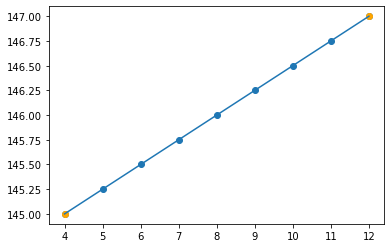

In [62]:
plotPatient(7, 'Platelets')

In [63]:
import panel as pn

pn.extension()

pn.interact(plotPatient, patient=(1, len(clusteringPatients)), feature = list(clusteringPatients[0].interpolatedData.columns)).show()

Launching server at http://localhost:51907


C:\Users\benma\AppData\Local\Temp/ipykernel_5528/846929100.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


C:\Users\benma\AppData\Local\Temp/ipykernel_5528/2772982012.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, len(patient.topColumns.columns)/2, idx+1)


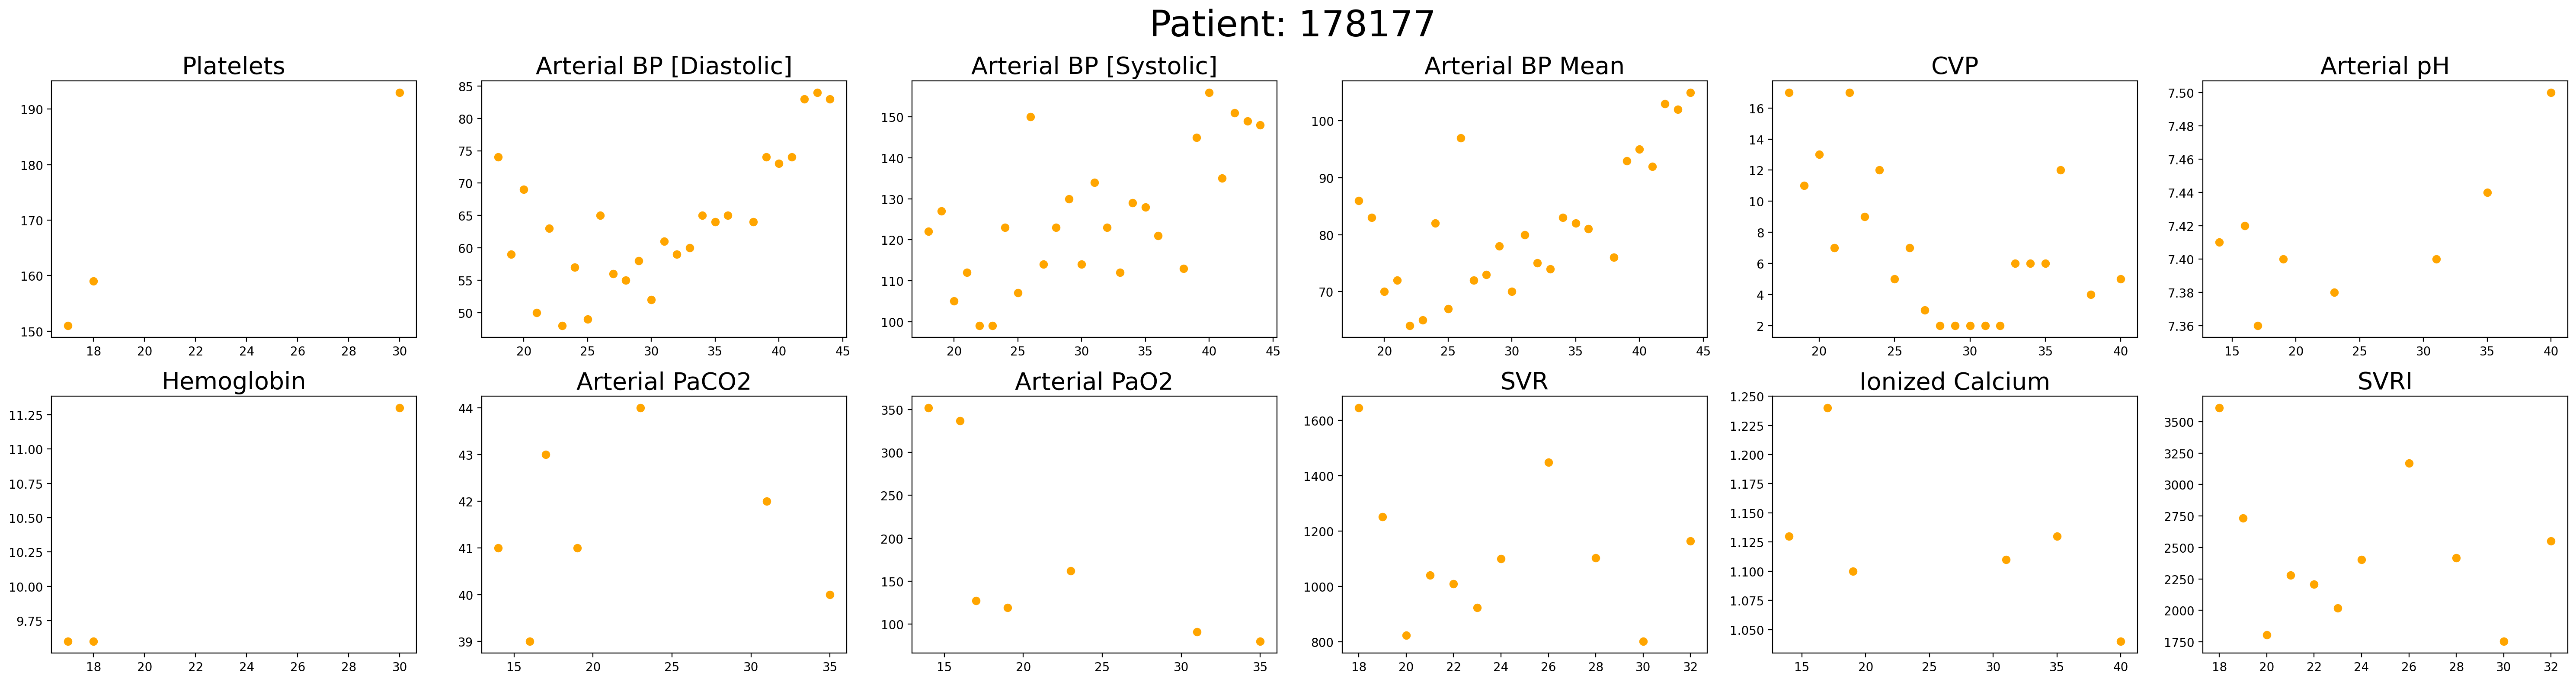

In [64]:
patient = clusteringPatients[0]

fig = plt.figure(figsize = (30, 8), dpi=200)


fig.suptitle(f"Patient: {patient.patientID}", fontsize=30)

for idx, col in enumerate(patient.topColumns.columns):
    plt.subplot(2, len(patient.topColumns.columns)/2, idx+1)

    plt.scatter(patient.topColumns.index, patient.topColumns[col], c='Orange')
    plt.title(f"{col}", fontsize=20)

plt.tight_layout()
plt.show()

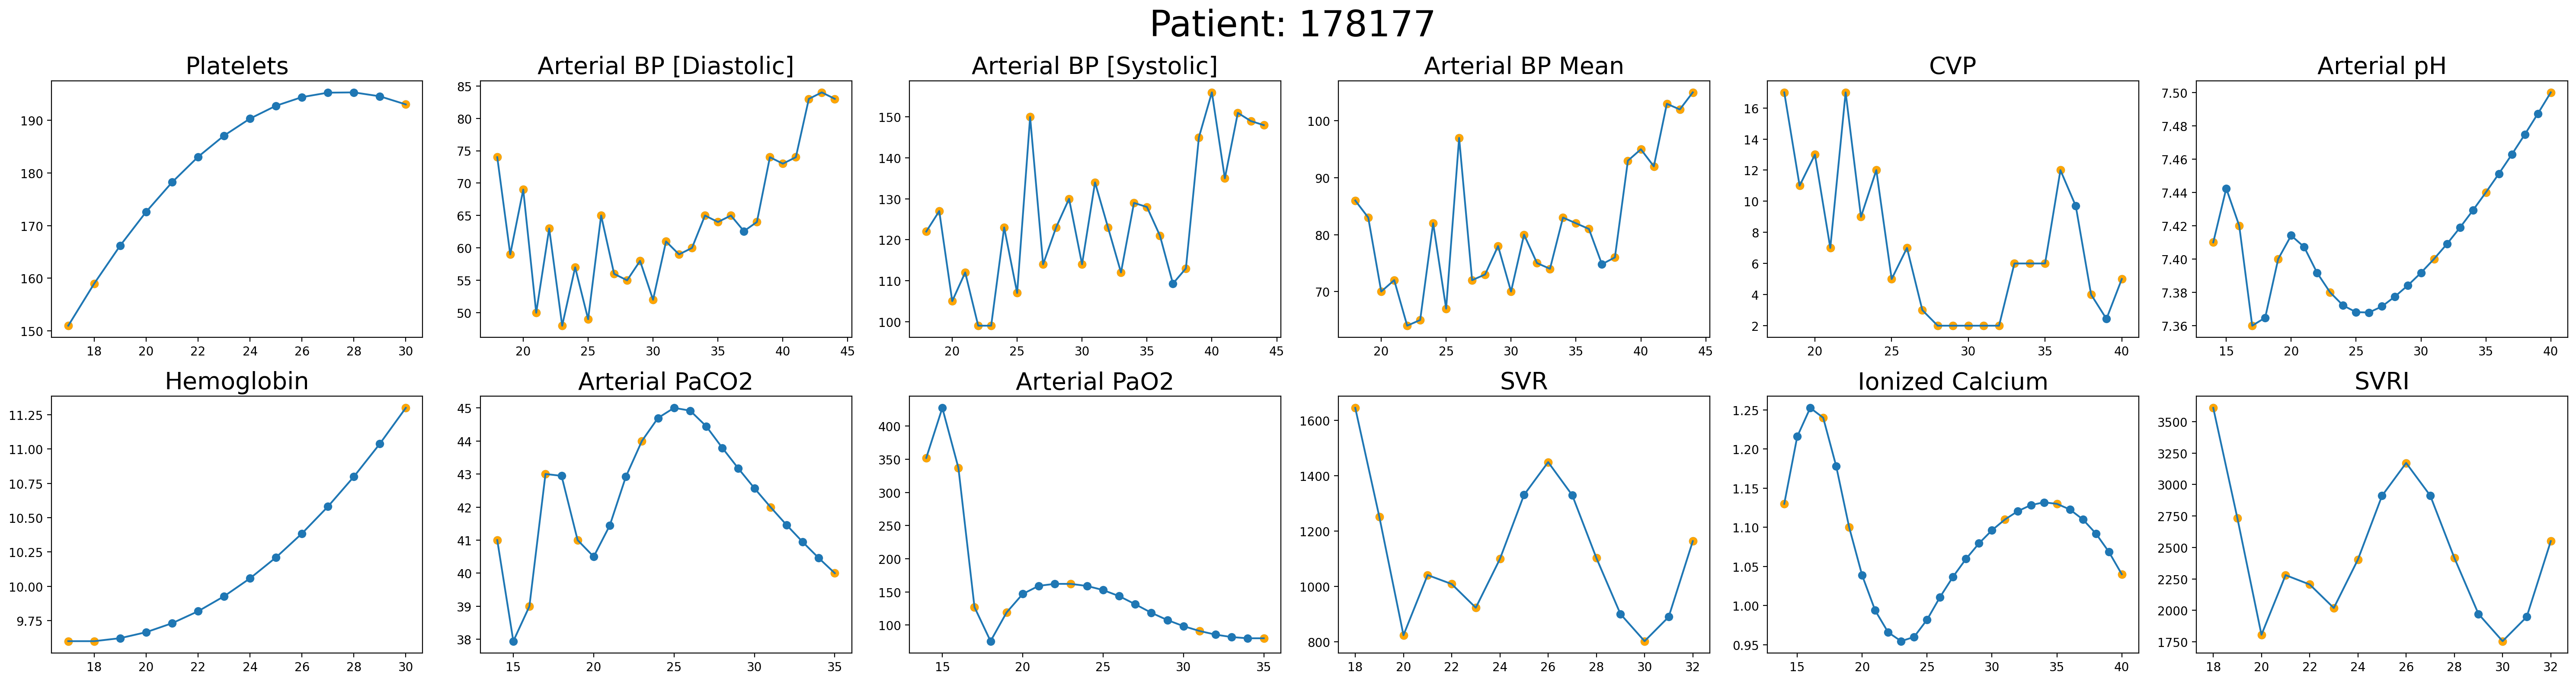

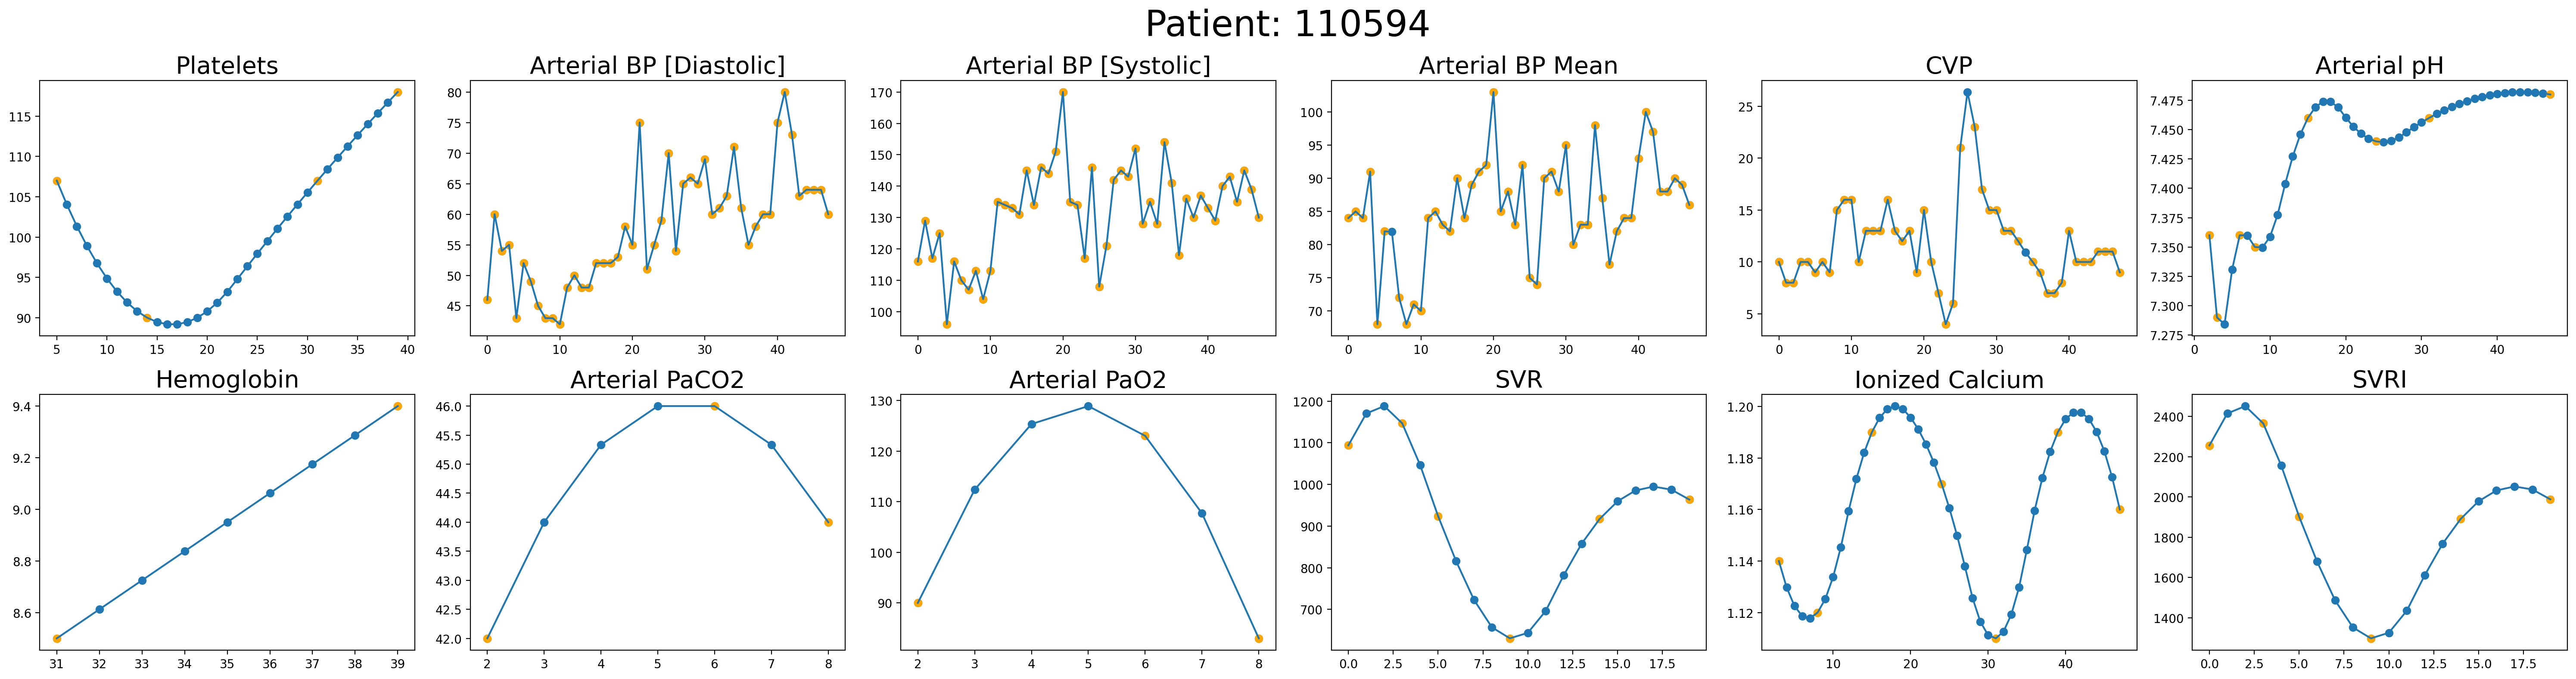

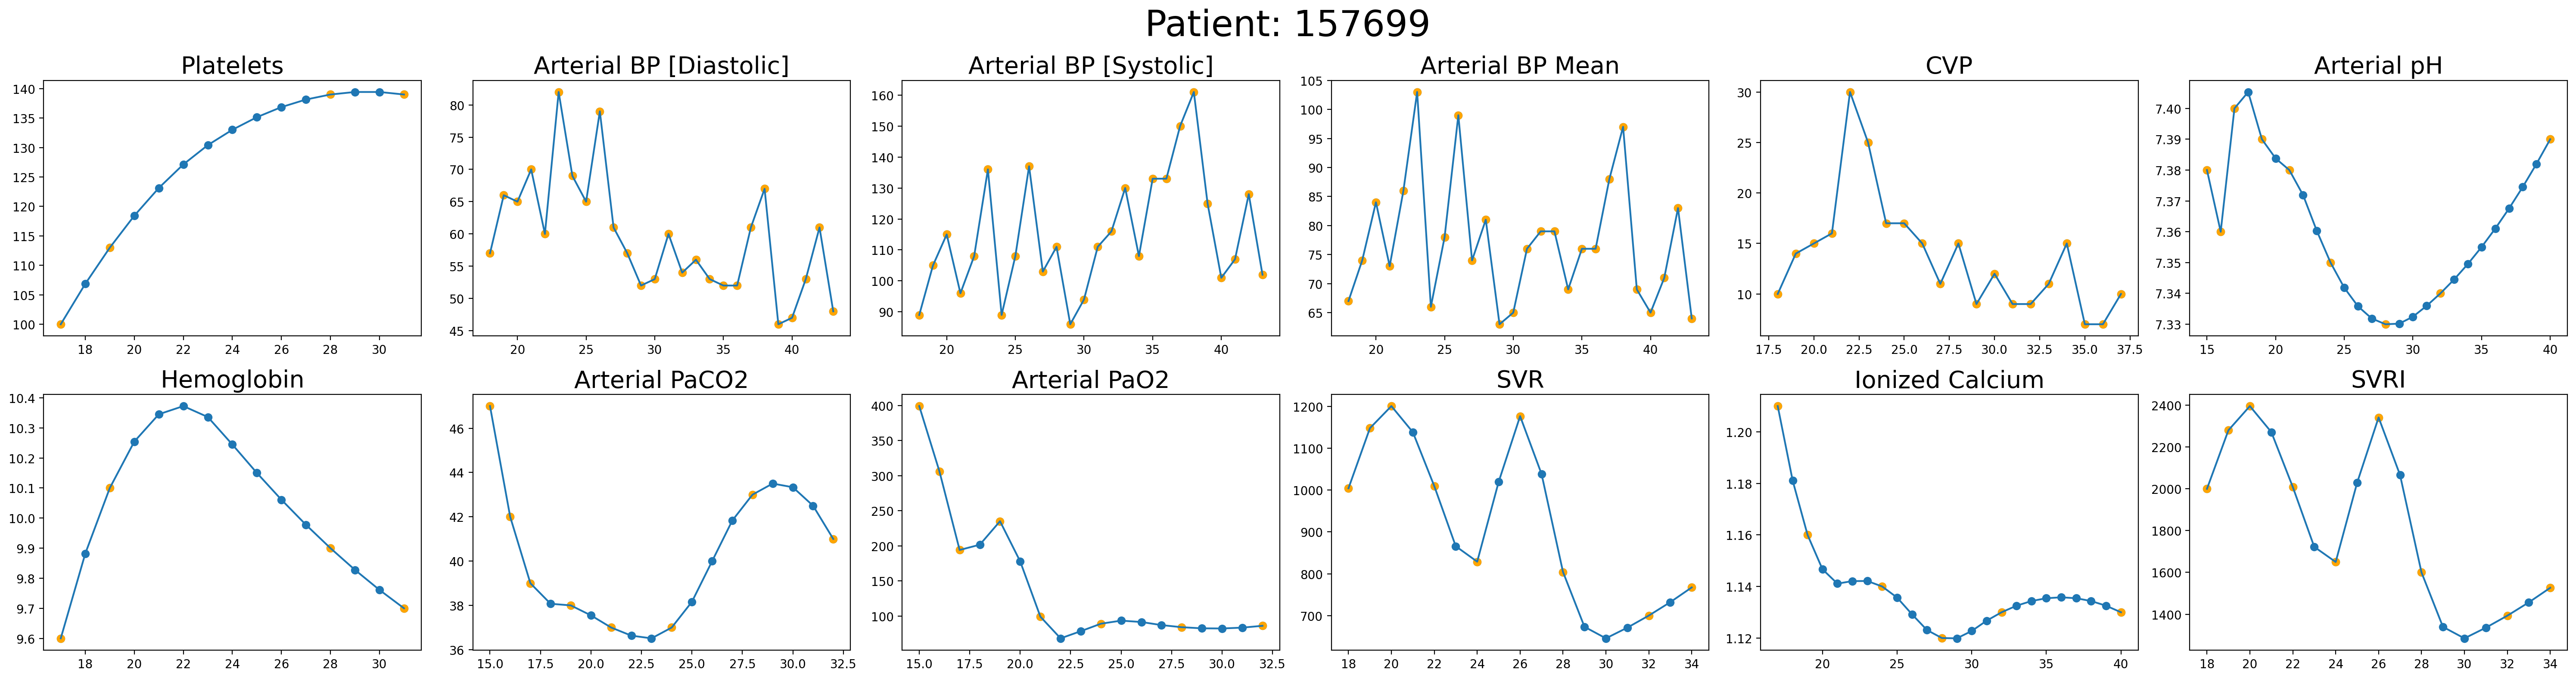

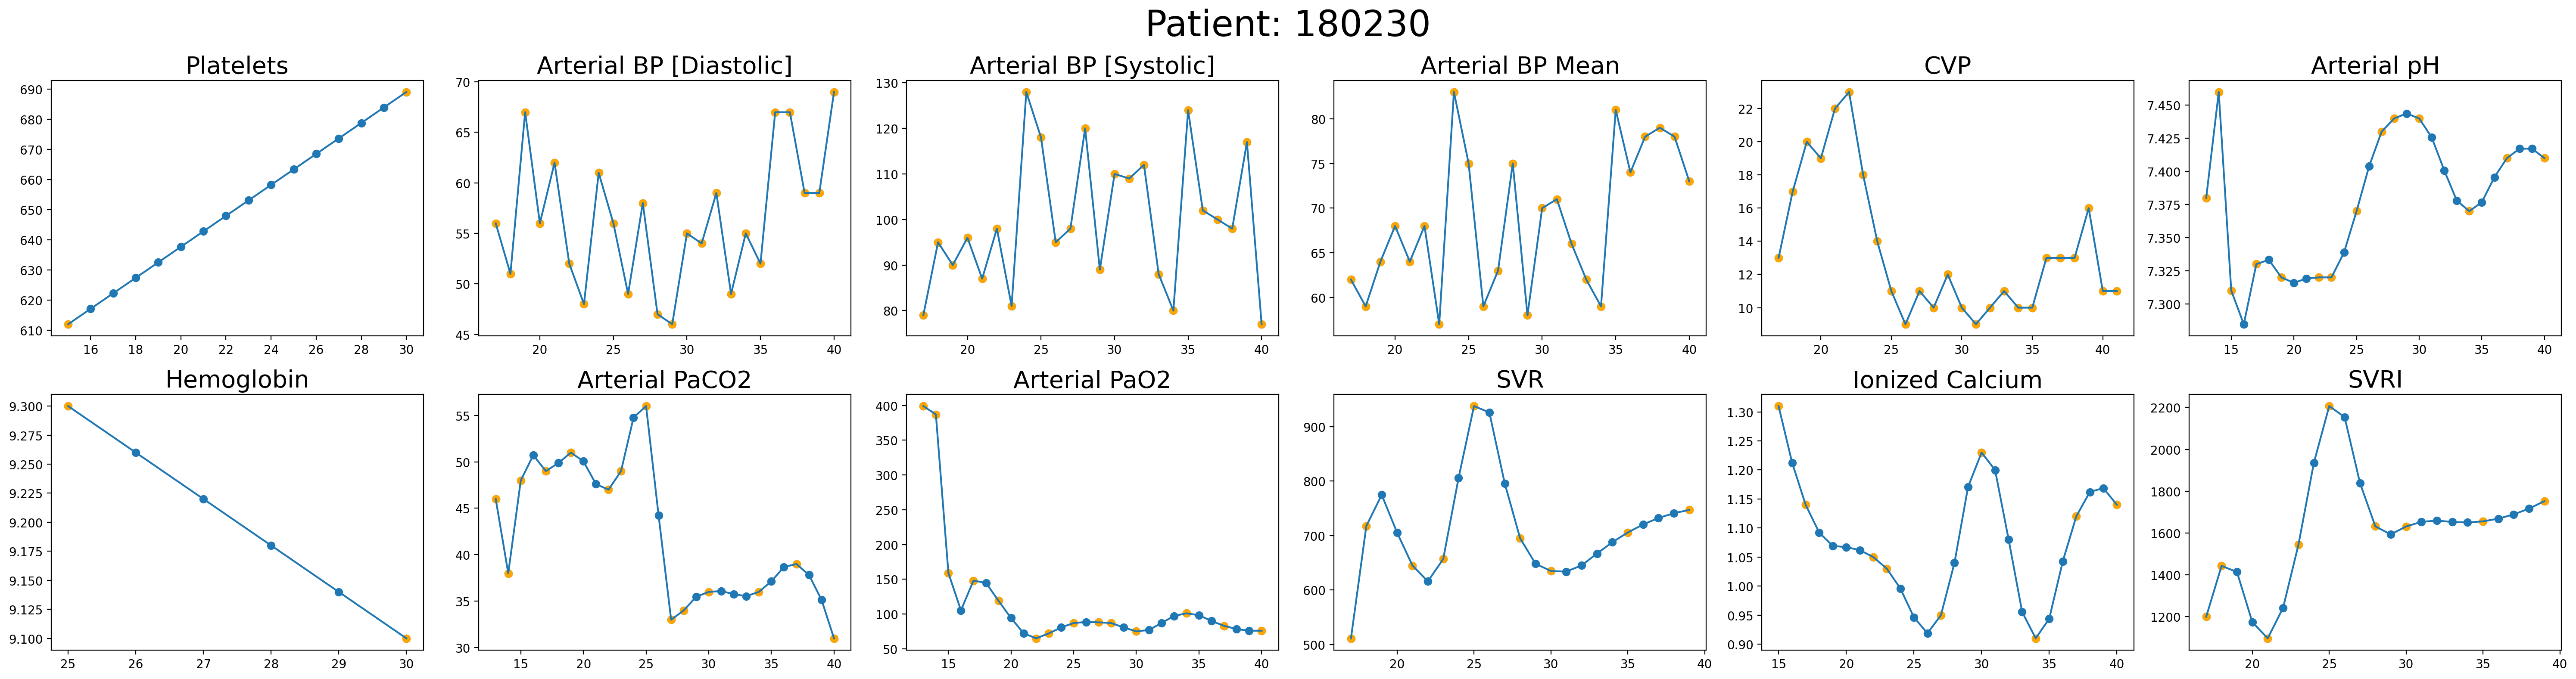

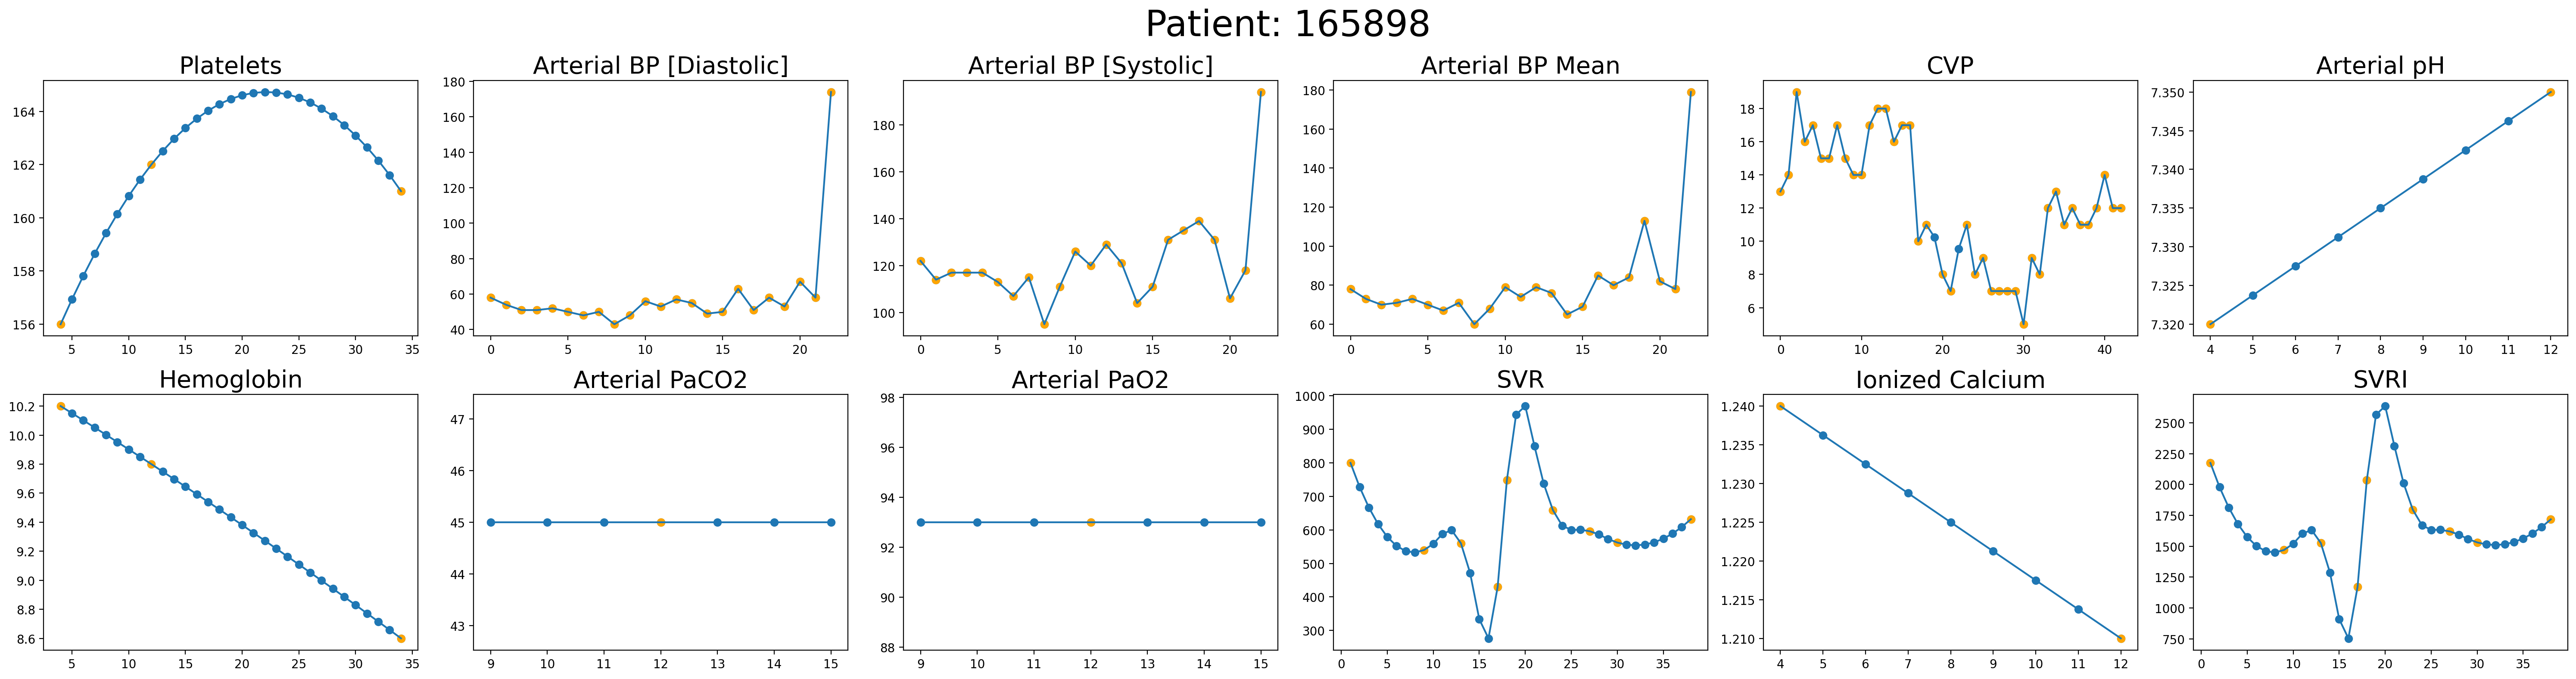

In [65]:
# TODO make these graphs bigger...


for patient in clusteringPatients[:5]:

    # display(clusteringPatients[i].interpolatedData.head())

    fig = plt.figure(figsize = (30, 8),dpi=200)


    fig.suptitle(f"Patient: {patient.patientID}", fontsize=30)

    for idx, col in enumerate(patient.interpolatedData.columns):
        plt.subplot(2, len(patient.interpolatedData.columns)//2, idx+1)

        plt.plot(patient.interpolatedData.index, patient.interpolatedData[col])
        plt.scatter(patient.interpolatedData.index, patient.interpolatedData[col])
        plt.scatter(patient.topColumns.index, patient.topColumns[col], c="Orange")
        plt.title(f"{col}", fontsize=20)

    plt.tight_layout()
    plt.show()

In [208]:

def formatForTimeSeries(column):

    stackedDF = pd.DataFrame([patient.interpolatedData[column].values for patient in clusteringPatients])

    # print(stackedDF.shape)


    stackedNumpy = stackedDF.to_numpy()

    cleanedNumpy = []

    for row in stackedNumpy:
        cleanedNumpy.append(row[~np.isnan(row)])


    dataFormatted = to_time_series_dataset([*cleanedNumpy])

    return dataFormatted



def timeSeriesCluster(clusters, dataFormatted):

    # print(f"Clustering {column}")

    # dataFormatted = formatForTimeSeries(column)

    # print(dataFormatted)


    # Change hyper-parameters for better results?

    # max iter 200 takes approx 4 minutes
    model = TimeSeriesKMeans(n_clusters=clusters, metric="dtw", max_iter=10, random_state=0, n_jobs=4)
    y_pred = model.fit_predict(dataFormatted)

    # Calculating the score takes ages
    # print(silhouette_score(dataFormatted, y_pred))

    

    return y_pred, model



# Has it's own silhouette_score
# print(silhouette_score(data, y_pred))


In [209]:
def find_cached(df=None, hash=None):

    if hash is None:

        print("Hashing...")
        hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + hash + ".csv").set_index("PatientID")

        print("Using cached df")

        return cachedDF, hash

    except:

        print("No cached df found")

        return False, hash
    

In [232]:
myHash = "Chosen_clusters"


clusteredDF, myHash = find_cached(clusteringPatients, hash=myHash)

# clusters = 5


clusterNums = {"Platelets": 3, "Arterial BP [Diastolic]": 2, "Arterial BP [Systolic]": 2, "Arterial BP Mean": 2, "CVP": 2, "Arterial pH": 2, "Hemoglobin": 2, "Arterial PaCO2": 2, "Arterial PaO2": 2, "SVR": 2, "Ionized Calcium": 2, "SVRI": 2}

# Caching disabled
if clusteredDF is False:

    clusteredDF = pd.DataFrame()

    for column in tqdm(clusterNums):
        dataFormatted = formatForTimeSeries(column)
        y_pred, model = timeSeriesCluster(clusterNums[column], dataFormatted)
        clusteredDF[column] = y_pred

    ids = [patient.patientID for patient in clusteringPatients]

    clusteredDF["PatientID"] = ids

    clusteredDF = clusteredDF.set_index("PatientID")


    clusteredDF.to_csv("./processingCache/" + myHash + ".csv")

# else:
#     dataFormatted = formatForTimeSeries(column)
        


'Chosen_clusters'

Using cached df


In [ ]:
# colScores = {}

# for col in tqdm(clusteringPatients[0].interpolatedData.columns):
    
#     results = []

#     dataFormatted = formatForTimeSeries(col)
    
#     for c in range(2,11):
        
#         y_pred, model = timeSeriesCluster(c, dataFormatted)

#         score = silhouetteScoreCalc(dataFormatted, y_pred)

#         print(f"Score: {score}")

#         results.append([c, score, y_pred])

#     colScores[col] = results


In [185]:
# print(list(range(2,12)))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [197]:
# [print(x) for x in list(colScores.keys())]

Platelets
Arterial BP [Diastolic]
Arterial BP [Systolic]
Arterial BP Mean
CVP
Arterial pH
Hemoglobin
Arterial PaCO2
Arterial PaO2
SVR
Ionized Calcium
SVRI


[None, None, None, None, None, None, None, None, None, None, None, None]

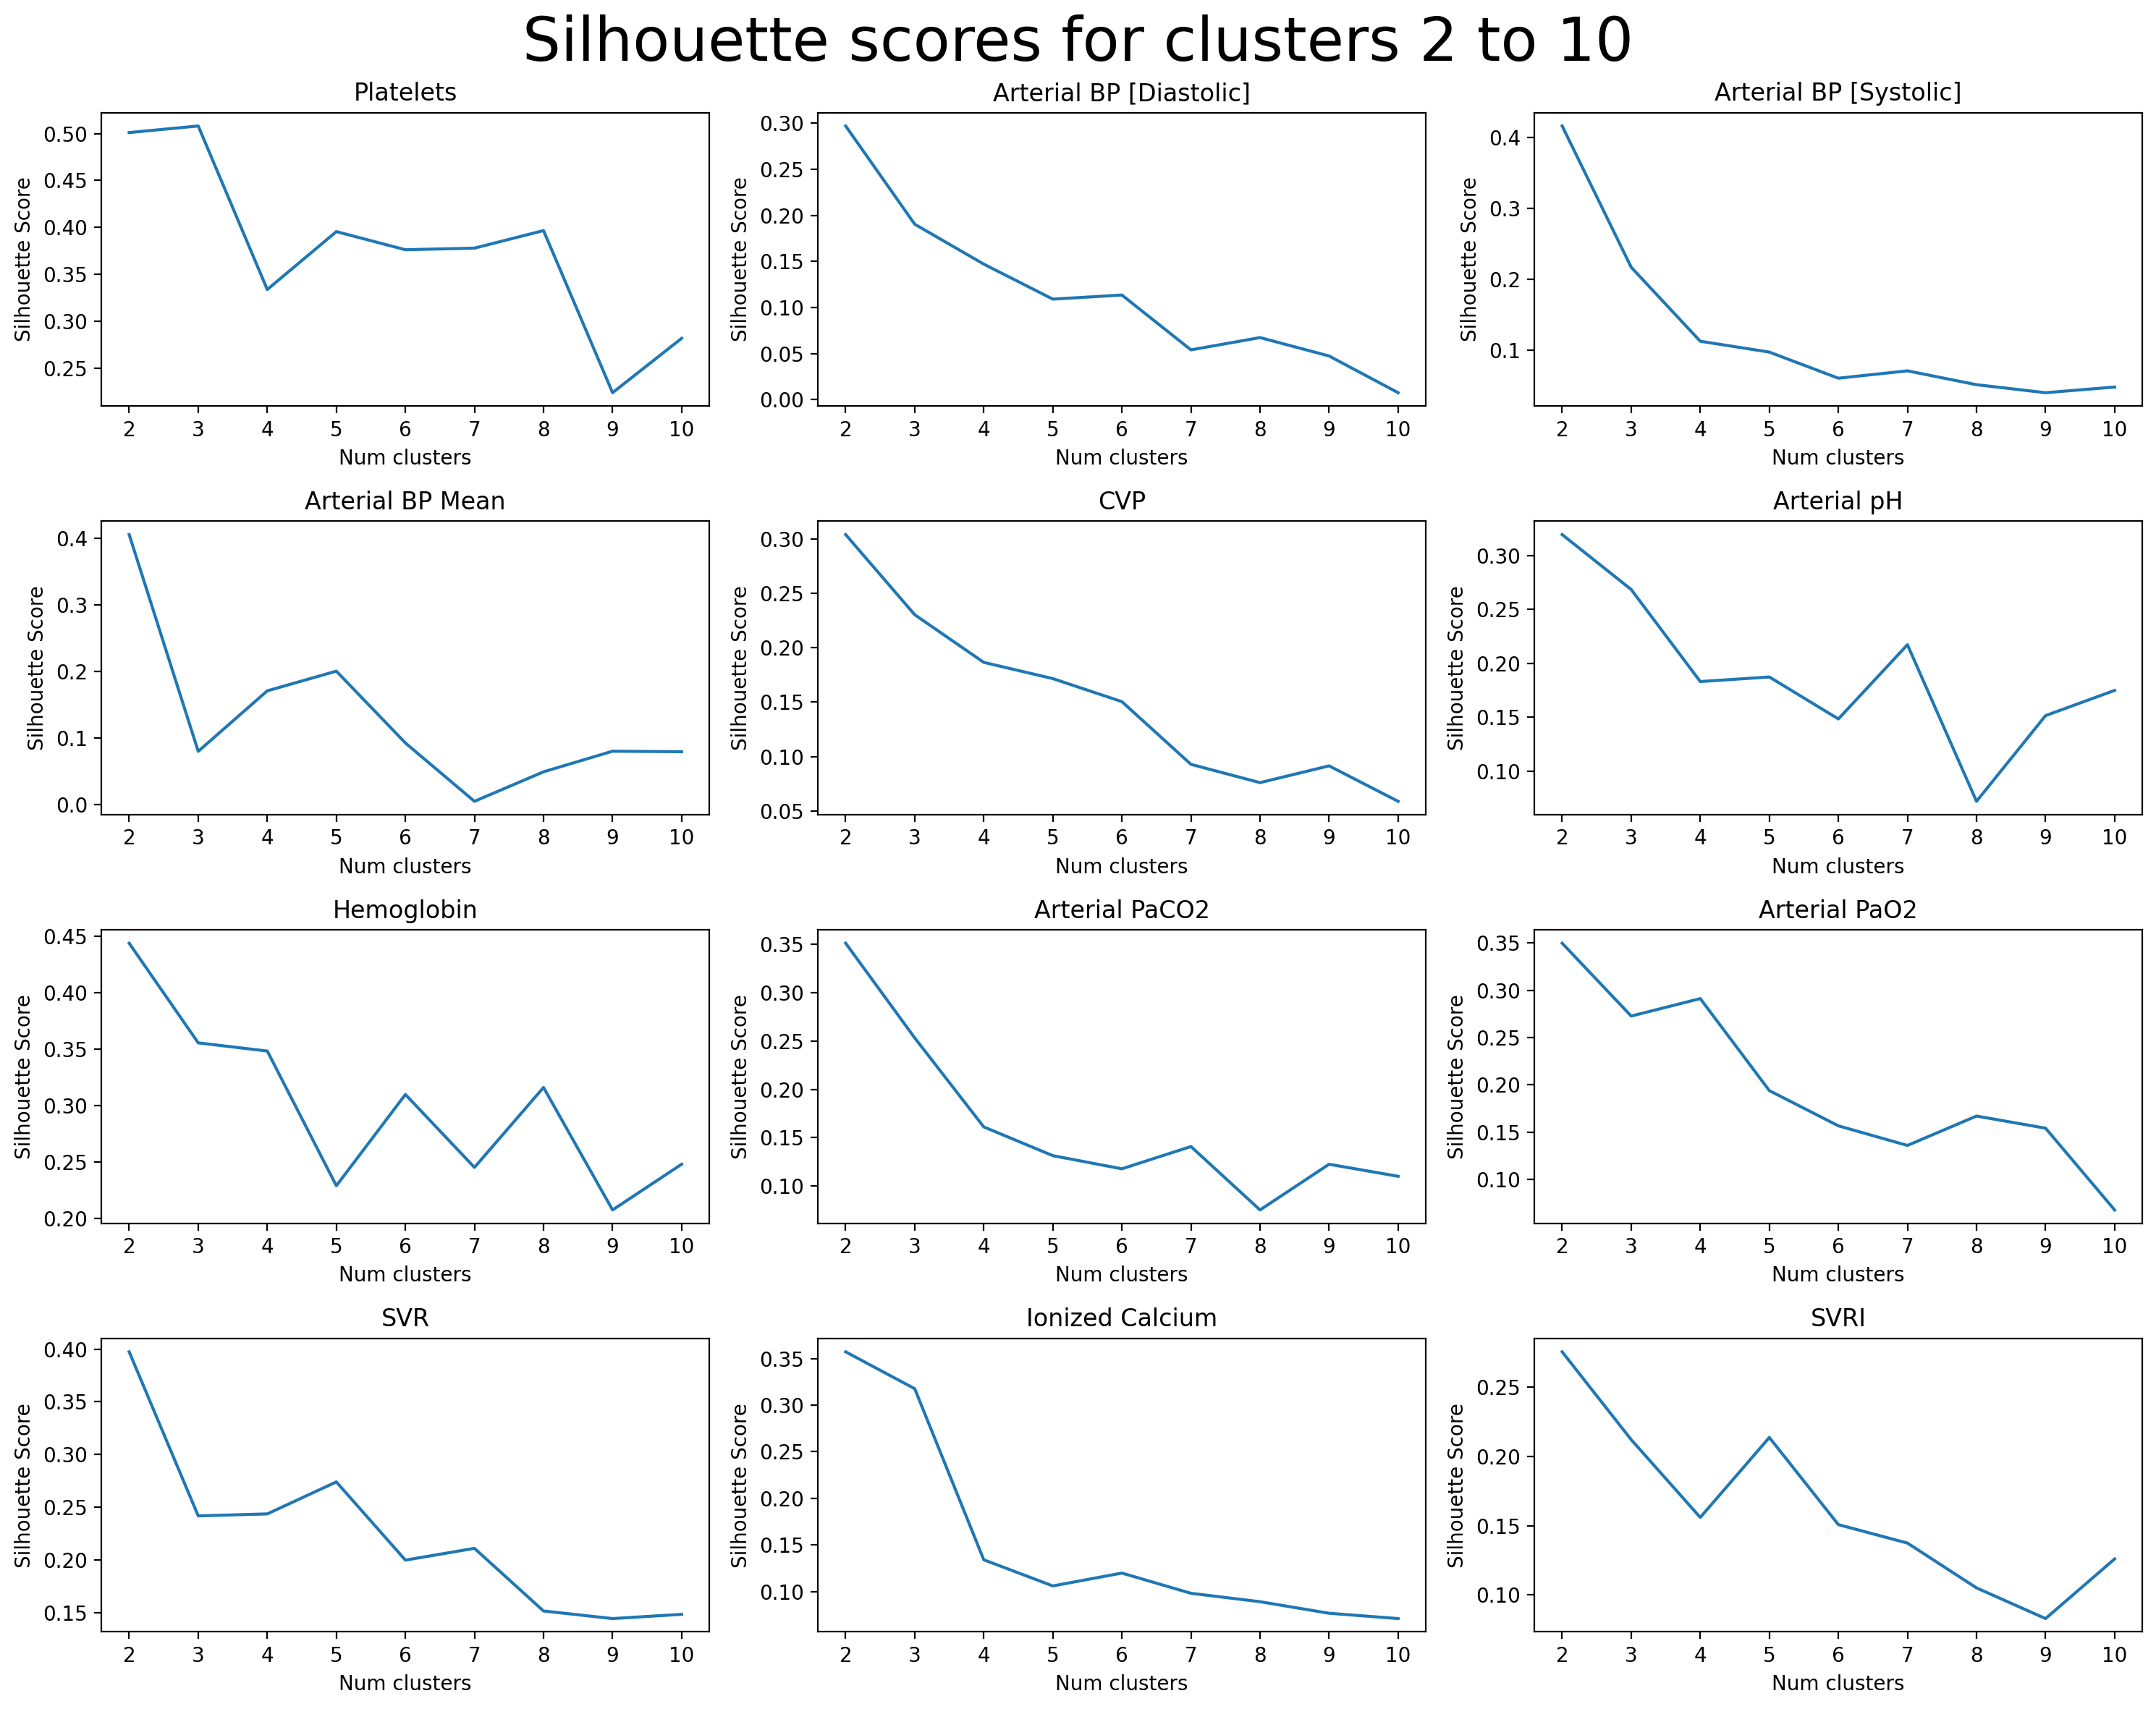

In [194]:
# fig = plt.figure(figsize = (15, 12), dpi=200)

# for idx, col in enumerate(colScores):
#     scores = [x[1] for x in colScores[col]]
#     plt.subplot(4, len(colScores)//4, idx+1)
#     plt.title(col)
#     plt.ylabel("Silhouette Score")
#     plt.xlabel("Num clusters")
#     plt.plot(list(range(2,2+len(scores))), scores)
    
# fig.suptitle(f"Silhouette scores for clusters 2 to {1+len(scores)}", fontsize=30)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(colScores)

In [212]:
clusteredDF.describe()

Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
count  959.000000               959.000000              959.000000   
mean     1.027112                 0.694473                0.102190   
std      0.964557                 0.460870                0.303056   
min      0.000000                 0.000000                0.000000   
25%      0.000000                 0.000000                0.000000   
50%      1.000000                 1.000000                0.000000   
75%      2.000000                 1.000000                0.000000   
max      2.000000                 1.000000                1.000000   

       Arterial BP Mean         CVP  Arterial pH  Hemoglobin  Arterial PaCO2  \
count        959.000000  959.000000   959.000000  959.000000      959.000000   
mean           0.816475    0.574557     0.576642    0.380605        0.363921   
std            0.387298    0.494668     0.494349    0.485789        0.481377   
min            0.000000    0.000000     0.000000    0.000000        0.000000   
25%            1.000000    0.000000     0.000000    0.000000        0.000000   
50%            1.000000    1.000000     1.000000    0.000000        0.000000   
75%            1.000000    1.000000     1.000000    1.000000        1.000000   
max            1.000000    1.000000     1.000000    1.000000        1.000000   

       Arterial PaO2         SVR  Ionized Calcium        SVRI  
count     959.000000  959.000000       959.000000  959.000000  
mean        0.362878    0.727842         0.216893    0.616267  
std         0.481081    0.445303         0.412344    0.486548  
min         0.000000    0.000000         0.000000    0.000000  
25%         0.000000    0.000000         0.000000    0.000000  
50%         0.000000    1.000000         0.000000    1.000000  
75%         1.000000    1.000000         0.000000    1.000000  
max         1.000000    1.000000         1.000000    1.000000

In [213]:
def silhouetteScoreCalc(data, y_pred):

    test_size = 0.1
    sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
    # print(y_pred)
    test_sample_x = data[sample_idx]
    test_sample_y = [y_pred[i] for i in sample_idx]
    
    while len(np.unique(test_sample_y)) < 2:
        print("Recalculating sample due to too few clusters")
        sample_idx = np.random.choice(data.shape[0], int(test_size * len(data)), replace=False)
        test_sample_x = data[sample_idx]
        test_sample_y = [y_pred[i] for i in sample_idx]

    score = silhouette_score(test_sample_x, test_sample_y, metric='dtw')

    return score


In [214]:


scores = {}

# Using sampling for the silhouette score since calculating the score on the entire dataset takes ages
# Is this calculated right? Sampling gives poor results
for column in tqdm(clusteredDF.columns):
    y_pred = list(clusteredDF[column])
    test_size = 0.1
    dataFormatted = formatForTimeSeries(column)
    
    score = silhouetteScoreCalc(dataFormatted, y_pred)


    scores[column] = score

print(scores)

# display(clusteredDF)

100%|██████████| 12/12 [00:16<00:00,  1.42s/it]

{'Platelets': 0.4388387431189584, 'Arterial BP [Diastolic]': 0.2958517164387735, 'Arterial BP [Systolic]': 0.41307075030204154, 'Arterial BP Mean': 0.3957291462152692, 'CVP': 0.3366449248760349, 'Arterial pH': 0.3064558470294229, 'Hemoglobin': 0.3872868160142025, 'Arterial PaCO2': 0.2930951854709126, 'Arterial PaO2': 0.3314474607943418, 'SVR': 0.39779543865354045, 'Ionized Calcium': 0.2974713097474301, 'SVRI': 0.344422627833414}


In [215]:
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [216]:
def removeOutliers(data, threshold):
    stdDev = np.nanstd(data)
    # print(stdDev)
    mean = np.nanmean(data)
    # print(mean)
    normalised = [np.nanmean(np.abs(d - mean)) for d in data]
    mask = normalised < threshold * stdDev
    return data[mask], data[np.logical_not(mask)]

# Gradient capturing here!!!

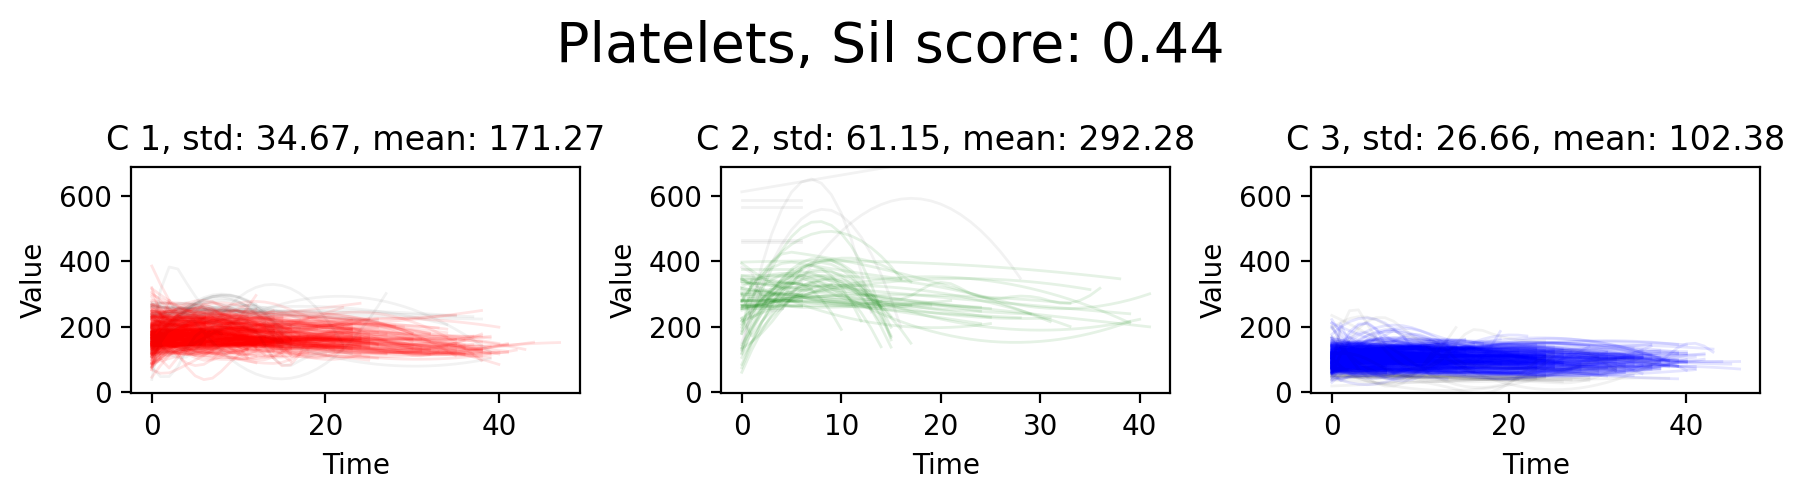

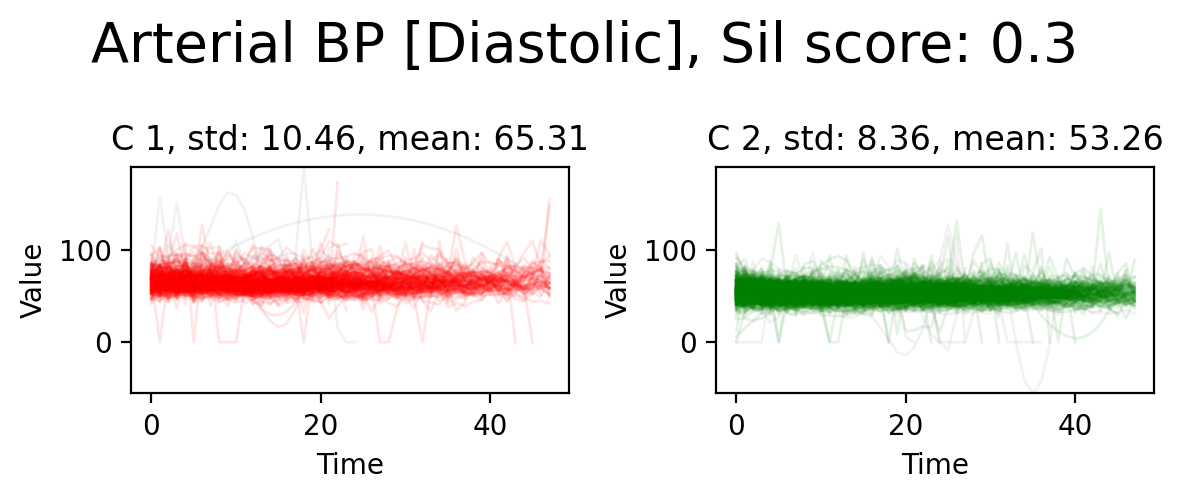

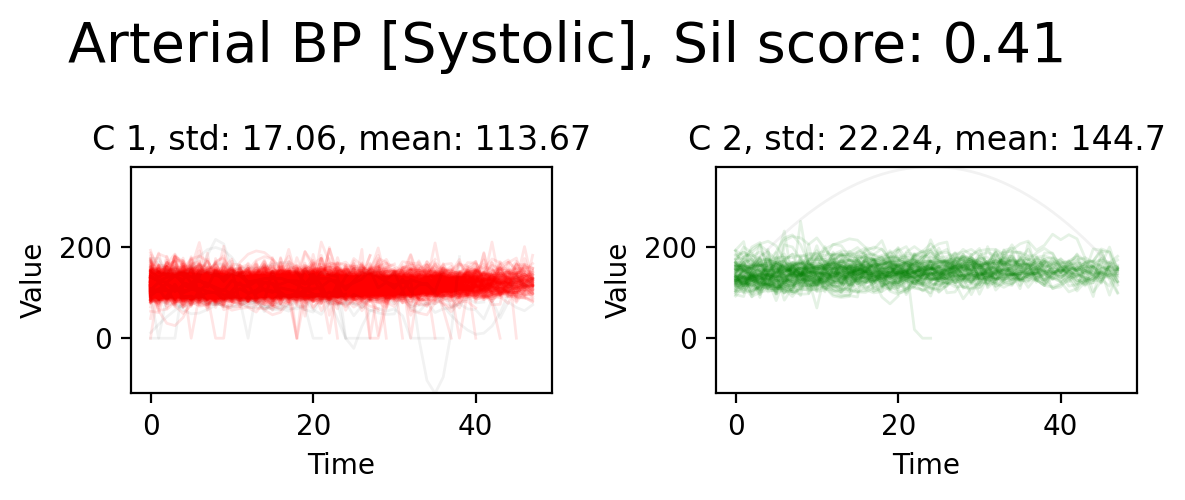

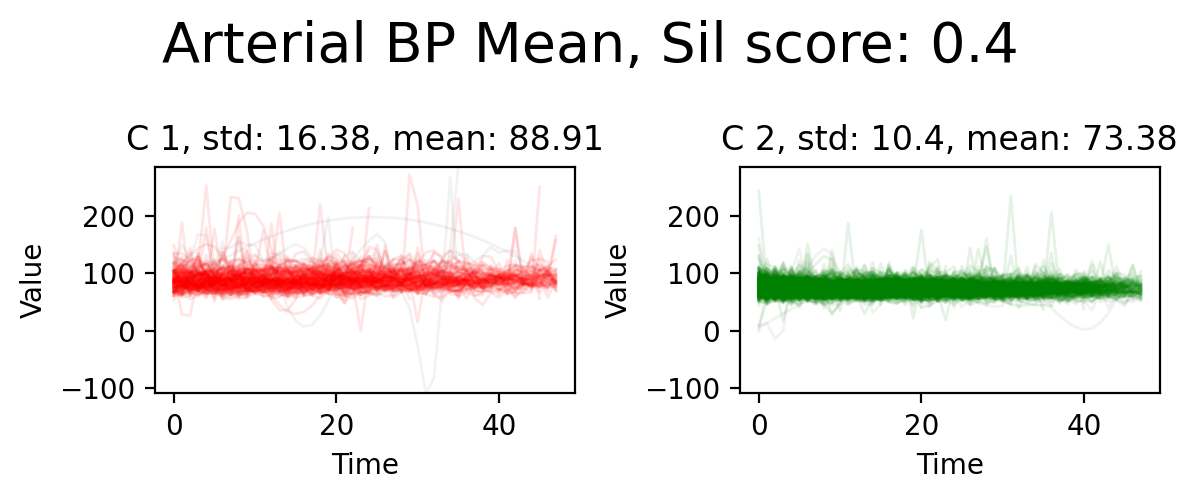

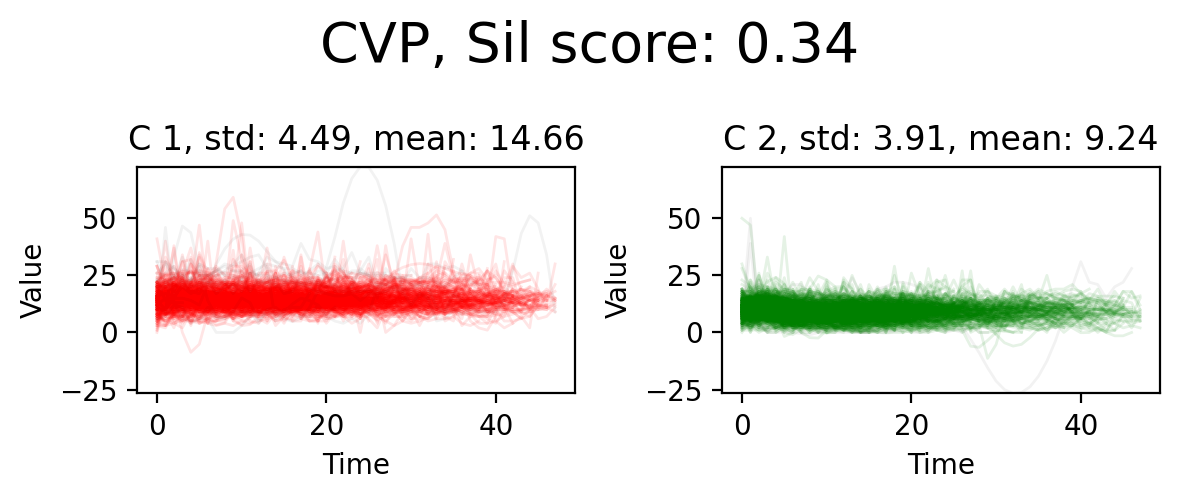

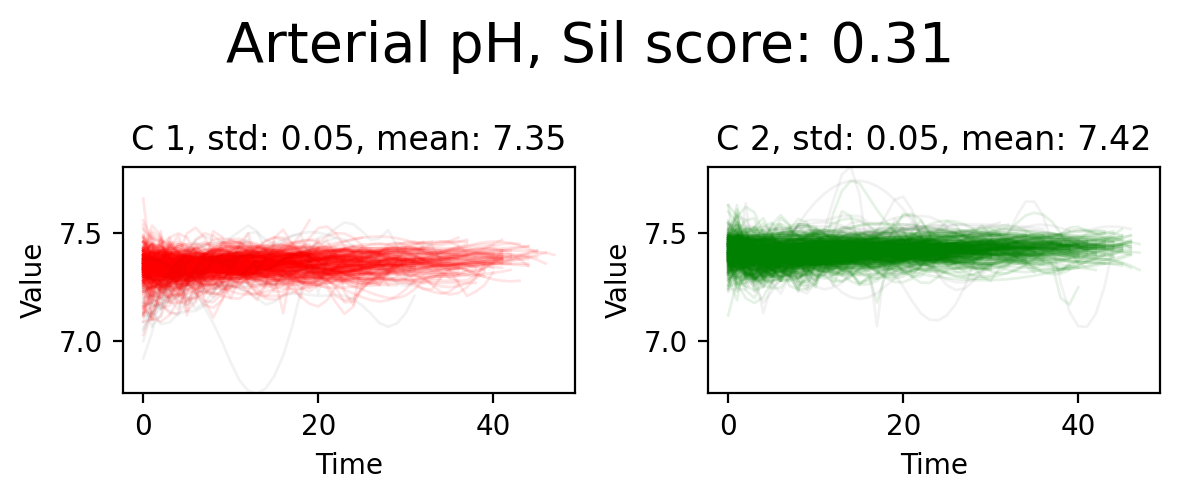

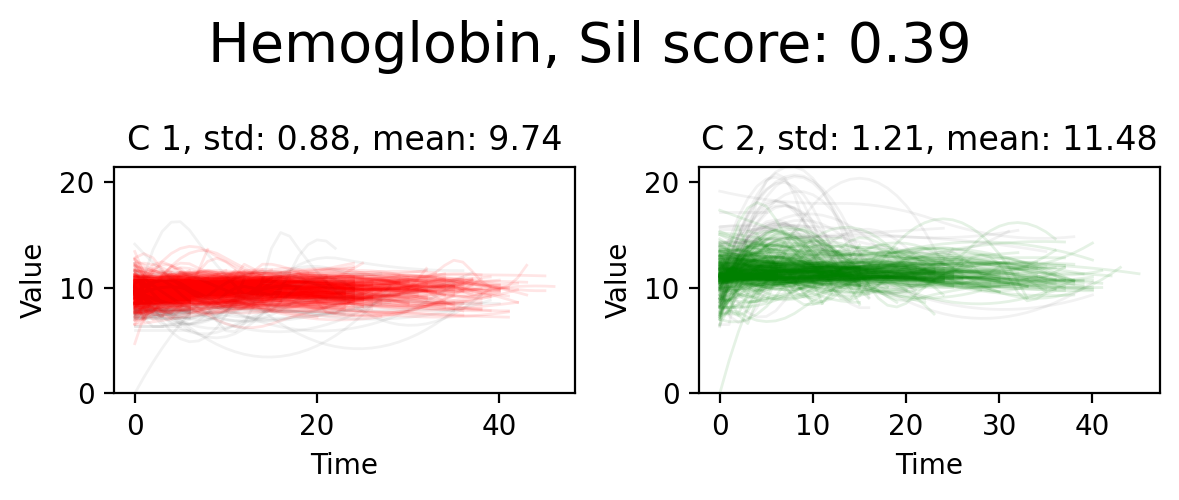

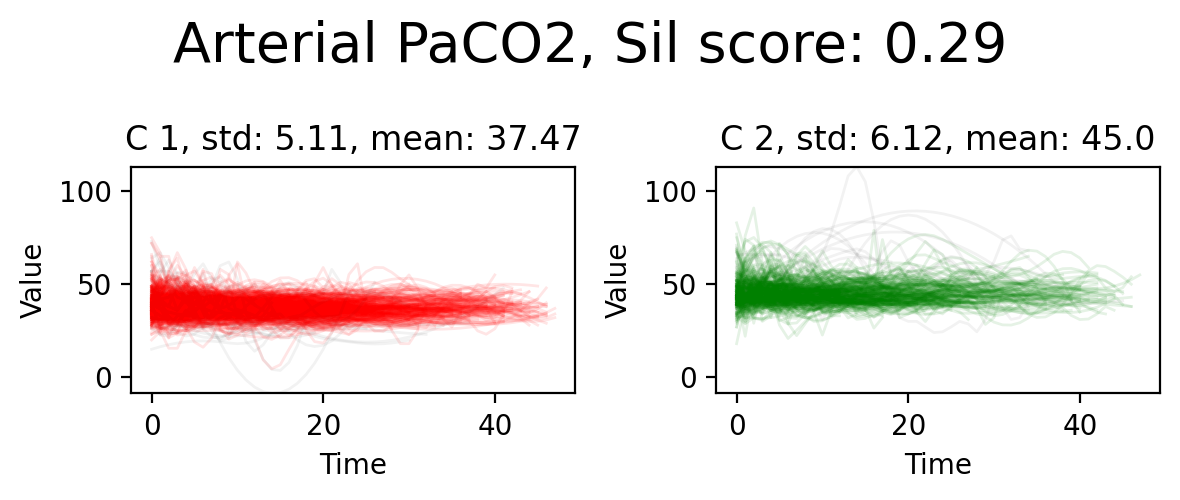

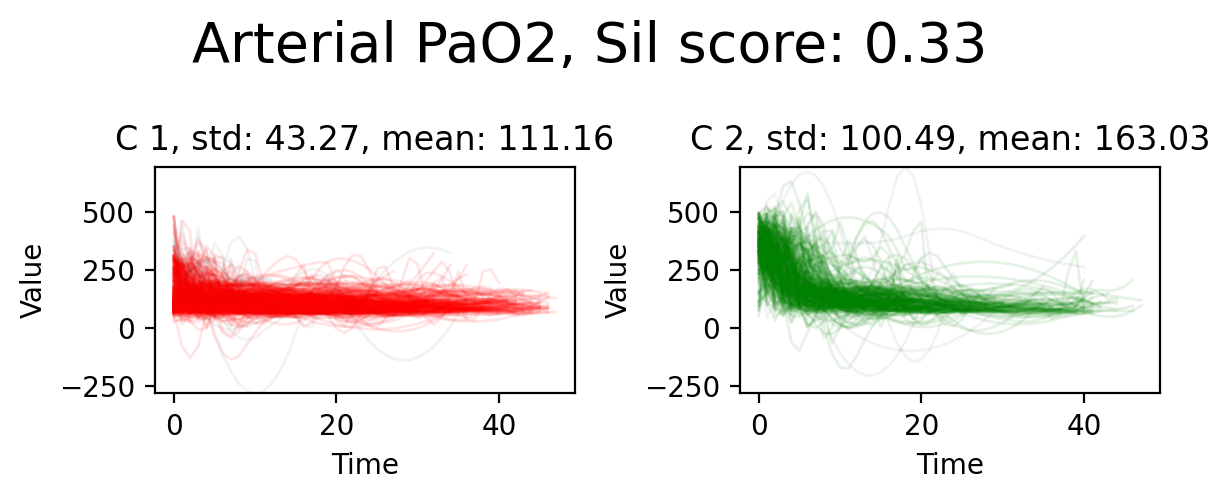

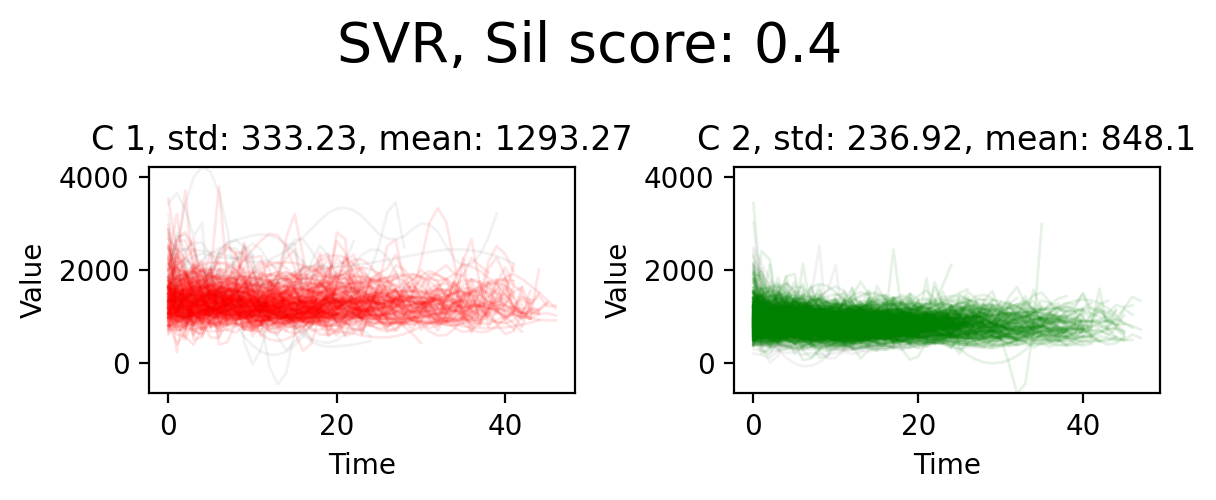

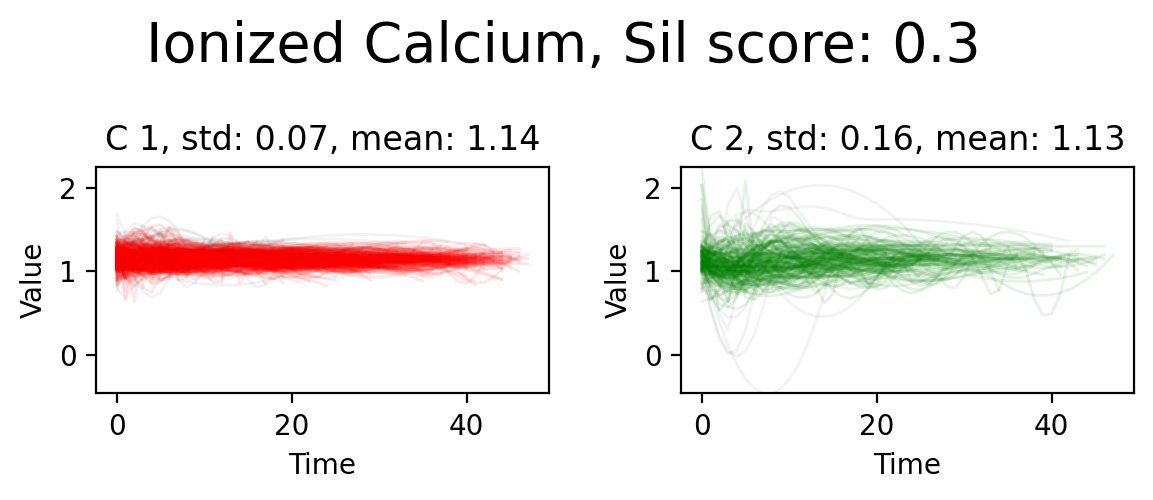

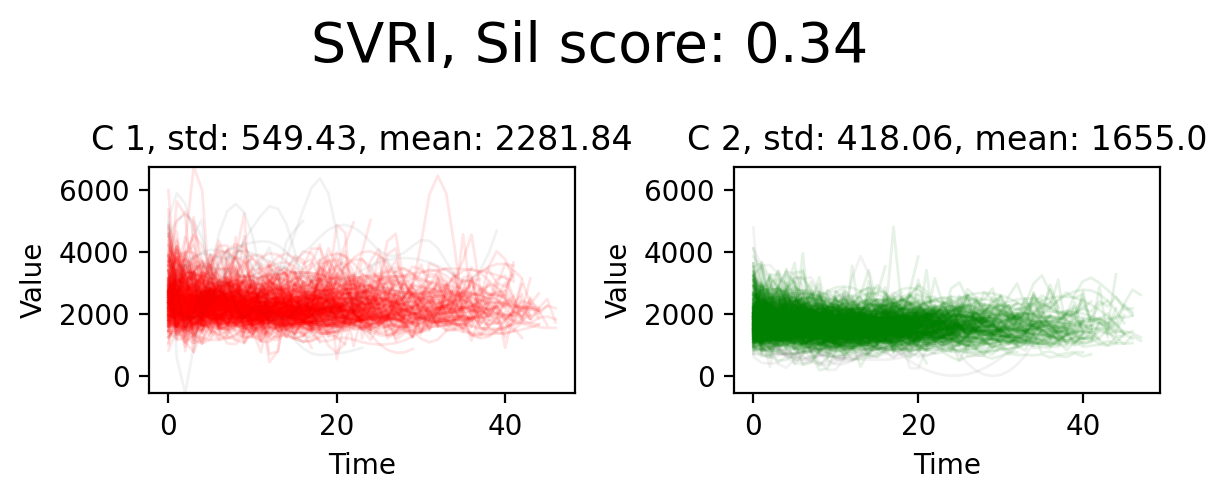

Feature      StdDev         Mean
0                 Platelets   34.668516   171.271503
1                 Platelets   61.148603   292.280514
2                 Platelets   26.658893   102.383034
3   Arterial BP [Diastolic]   10.458275    65.314415
4   Arterial BP [Diastolic]    8.360953    53.257598
5    Arterial BP [Systolic]   17.055131   113.669792
6    Arterial BP [Systolic]   22.242493   144.696171
7          Arterial BP Mean   16.377838    88.906187
8          Arterial BP Mean   10.404577    73.375113
9                       CVP    4.492892    14.662169
10                      CVP    3.907124     9.242431
11              Arterial pH    0.050700     7.353126
12              Arterial pH    0.046784     7.415297
13               Hemoglobin    0.883989     9.744967
14               Hemoglobin    1.206324    11.479151
15           Arterial PaCO2    5.114238    37.469757
16           Arterial PaCO2    6.118628    45.003066
17            Arterial PaO2   43.270139   111.160180
18            Arterial PaO2  100.492077   163.032974
19                      SVR  333.232421  1293.273603
20                      SVR  236.922288   848.098181
21          Ionized Calcium    0.073820     1.144451
22          Ionized Calcium    0.160644     1.126178
23                     SVRI  549.428390  2281.840137
24                     SVRI  418.060872  1654.995768

In [217]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}

clusterMetricsList = []

for col in clusterNums:

    clusters = clusterNums[col]

    fig = plt.figure(figsize=(clusters*3,2.5), dpi=200)

    fig.suptitle(f"{col}, Sil score: {np.round(scores[col], 2)}", fontsize=20)
    

    colData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]
    # print(colData)

    minVal, maxVal = np.nanmin([np.nanmin(j) for j in colData]), np.nanmax([np.nanmax(j) for j in colData])

    for i in range(clusters):
        plt.subplot(1, clusters, i+1)

        y_pred = clusteredDF[col]

        # dataCluster = np.array(colData)[y_pred == i]

        dataCluster = formatForTimeSeries(col)[y_pred == i]

        withoutOutliers, outliers = removeOutliers(dataCluster, 1.5)
        
        # print(f"Num removed: {len(dataCluster) - len(withoutOutliers)}")

        # print(len(dataCluster))
        # print(len(withoutOutliers))
        
        for sample in outliers:
            plt.plot(sample, c='black', alpha=0.05, linewidth=1)
        
        for sample in withoutOutliers:
            plt.plot(sample, c=colours[i], alpha=0.1, linewidth=1)

        stdDev = np.nanstd(withoutOutliers)
        mean = np.nanmean(withoutOutliers)

        clusterMetricsList.append([col, stdDev, mean])

        plt.title(f"C {i+1}, std: {np.round(stdDev, 2)}, mean: {np.round(mean, 2)}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        # print(dataCluster)
        # print(np.nanstd(dataCluster))
        plt.ylim(minVal, maxVal)

        
    plt.tight_layout()
    plt.savefig(f"./figures/{col}.png")
    plt.show()
    


clusterMetricsDF = pd.DataFrame(data = clusterMetricsList, columns=['Feature', 'StdDev', 'Mean'])
display(clusterMetricsDF)


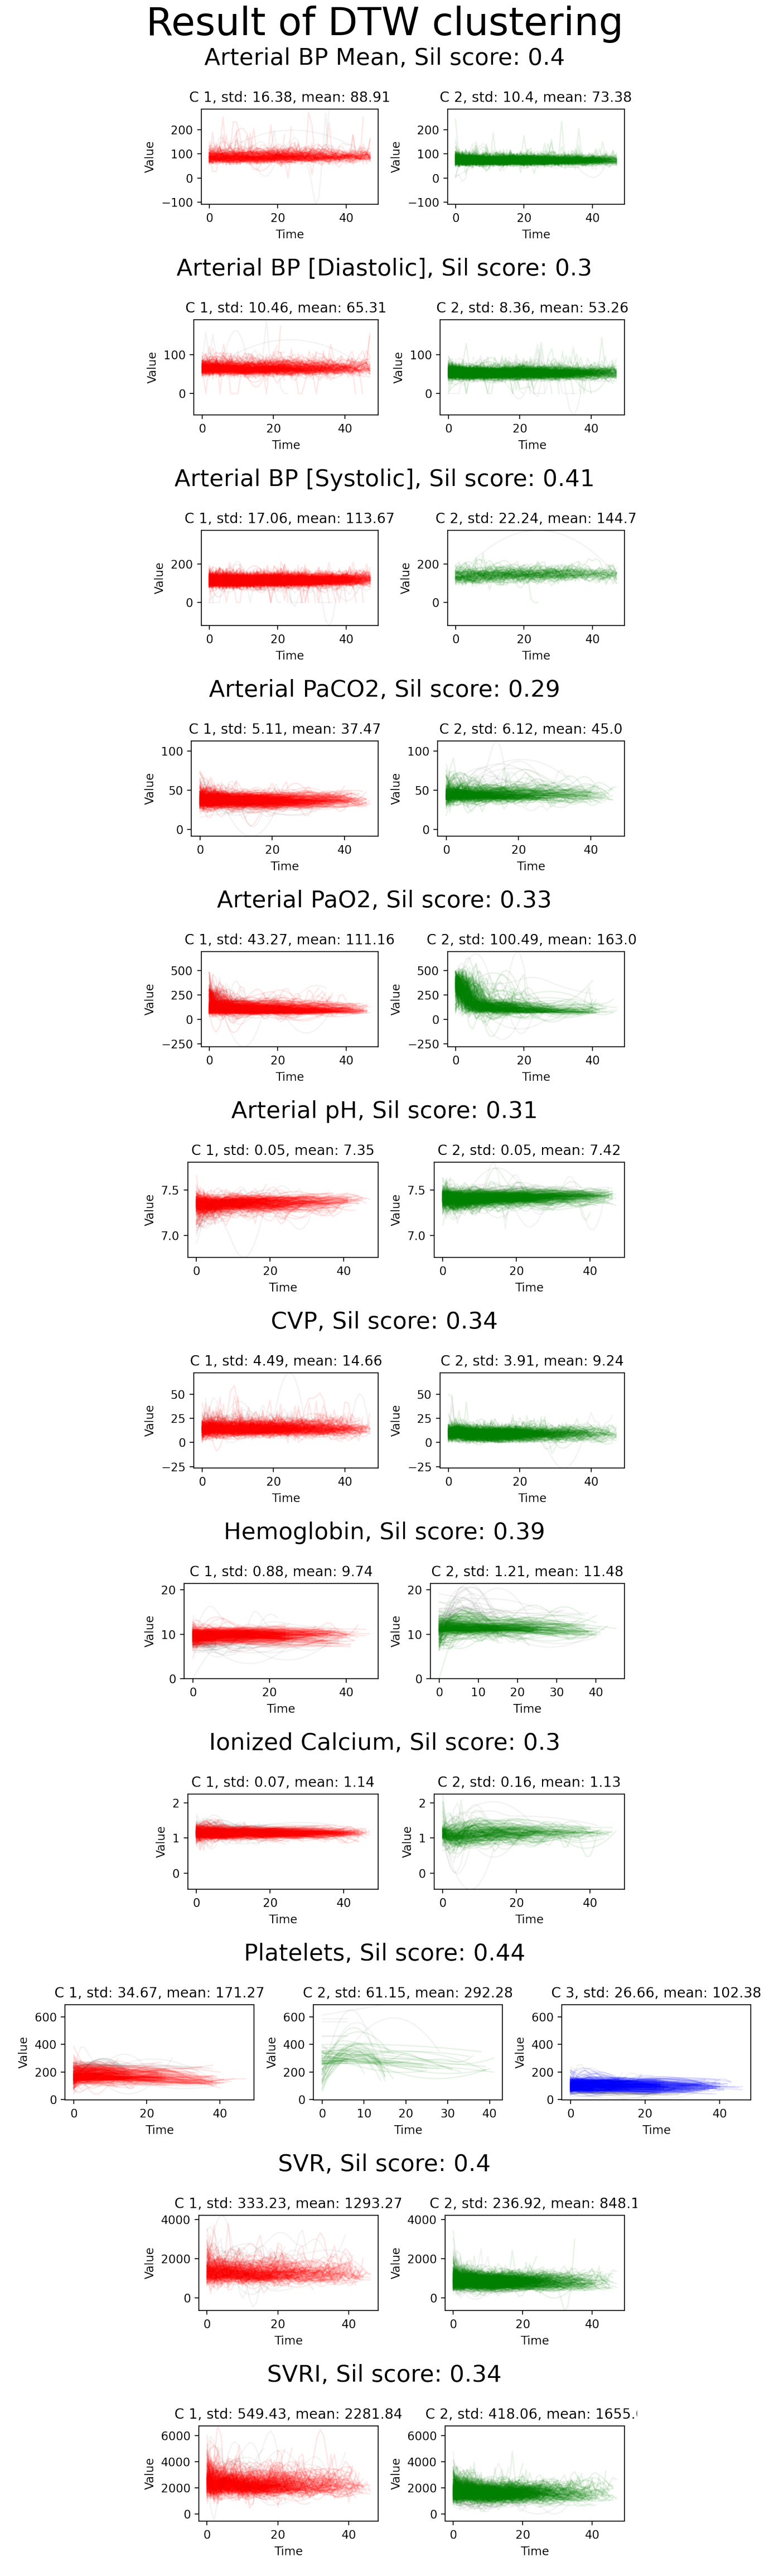

In [227]:
figdir = "./figures/"

images = [Image.open(figdir + x) for x in list(next(os.walk(figdir))[2:])[0]]

widths, heights = zip(*(i.size for i in images))

widthMax = max(widths)
widthMin = min(widths)
heightTotal = sum(heights)

combined = Image.new('RGBA', (widthMax, heightTotal))

offset = 0
for im in images:
  xOffset = 0
  if im.size[0] != widthMax:
    xOffset = (widthMax - im.size[0]) // 2
  combined.paste(im, (xOffset, offset))
  offset += im.size[1]


fig = plt.figure(figsize=(widthMax/100, heightTotal/100), dpi=100)
plt.title("Result of DTW clustering", fontsize=50)
plt.axis('off')
# plt.tight_layout()
plt.imshow(combined)
plt.show()


# new_im.save('test.jpg')

### Order by std dev to find the clusters that vary the most, order by mean to find the highest/lowest values.

In [230]:
# from sklearn.preprocessing import KBinsDiscretizer  
# est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

display(clusteredDF.head())

# orderedDF = copy.copy(clusteredDF)

def getMapping(metric, subset):
    
    ordered = subset.reset_index().sort_values(by=metric, ascending=True)

    before = ordered.index
    after = ordered.reset_index().index

    mapping = {before[i]: after[i] for i in range(len(before))}

    return mapping



orderedDF = pd.DataFrame()

for name, subset in clusterMetricsDF.groupby('Feature'):

    # clusterData = [np.pad(j.interpolatedData[col].values, (0, 48 - len(j.interpolatedData[col].values)), 'constant', constant_values = (np.NaN, np.NaN)) for j in clusteringPatients]

    for metric in list(clusterMetricsDF.columns)[1:]:

        mapping = getMapping(metric, subset)

        newCol = str(name + "_" + metric)

        orderedDF[newCol] = clusteredDF[name].map(mapping)


# orderedDF = orderedDF.set_index(clusteredDF.index)


display(orderedDF.head())


Platelets  Arterial BP [Diastolic]  Arterial BP [Systolic]  \
PatientID                                                               
178177             0                        0                       0   
110594             2                        1                       0   
157699             2                        0                       0   
180230             1                        1                       0   
165898             0                        0                       0   

           Arterial BP Mean  CVP  Arterial pH  Hemoglobin  Arterial PaCO2  \
PatientID                                                                   
178177                    0    1            1           0               1   
110594                    0    0            1           0               1   
157699                    1    0            0           0               0   
180230                    1    0            0           0               1   
165898                    0    0            0           0               1   

           Arterial PaO2  SVR  Ionized Calcium  SVRI  
PatientID                                             
178177                 1    0                0     0  
110594                 0    1                0     1  
157699                 1    1                0     1  
180230                 1    1                1     1  
165898                 0    1                0     1

StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean
StdDev
Mean


Arterial BP Mean_StdDev  Arterial BP Mean_Mean  \
PatientID                                                   
178177                           1                      1   
110594                           1                      1   
157699                           0                      0   
180230                           0                      0   
165898                           1                      1   

           Arterial BP [Diastolic]_StdDev  Arterial BP [Diastolic]_Mean  \
PatientID                                                                 
178177                                  1                             1   
110594                                  0                             0   
157699                                  1                             1   
180230                                  0                             0   
165898                                  1                             1   

           Arterial BP [Systolic]_StdDev  Arterial BP [Systolic]_Mean  \
PatientID                                                               
178177                                 0                            0   
110594                                 0                            0   
157699                                 0                            0   
180230                                 0                            0   
165898                                 0                            0   

           Arterial PaCO2_StdDev  Arterial PaCO2_Mean  Arterial PaO2_StdDev  \
PatientID                                                                     
178177                         1                    1                     1   
110594                         1                    1                     0   
157699                         0                    0                     1   
180230                         1                    1                     1   
165898                         1                    1                     0   

           Arterial PaO2_Mean  ...  Hemoglobin_StdDev  Hemoglobin_Mean  \
PatientID                      ...                                       
178177                      1  ...                  0                0   
110594                      0  ...                  0                0   
157699                      1  ...                  0                0   
180230                      1  ...                  0                0   
165898                      0  ...                  0                0   

           Ionized Calcium_StdDev  Ionized Calcium_Mean  Platelets_StdDev  \
PatientID                                                                   
178177                          0                     1                 1   
110594                          0                     1                 0   
157699                          0                     1                 0   
180230                          1                     0                 2   
165898                          0                     1                 1   

           Platelets_Mean  SVR_StdDev  SVR_Mean  SVRI_StdDev  SVRI_Mean  
PatientID                                                                
178177                  1           1         1            1          1  
110594                  0           0         0            0          0  
157699                  0           0         0            0          0  
180230                  2           0         0            0          0  
165898                  1           0         0            0          0  

[5 rows x 24 columns]

In [250]:
reload(Categorization)

cat = Categorization.Categorizer()

mapping = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

mapped = cat.map_types(data = {"ordered":orderedDF}, mapping={0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'})['ordered']

display(mapped)

got here
got here


Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
PatientID                                                              
178177                                1                            0   
110594                                1                            0   
157699                                0                            1   
180230                                0                            1   
165898                                1                            0   
...                                 ...                          ...   
196597                                0                            1   
116726                                0                            1   
169975                                0                            1   
147451                                0                            1   
159740                                0                            1   

           Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
PatientID                                                          
178177                              1                          0   
110594                              1                          0   
157699                              0                          1   
180230                              0                          1   
165898                              1                          0   
...                               ...                        ...   
196597                              0                          1   
116726                              0                          1   
169975                              0                          1   
147451                              0                          1   
159740                              0                          1   

           Arterial BP [Diastolic]_StdDev_high  \
PatientID                                        
178177                                       1   
110594                                       0   
157699                                       1   
180230                                       0   
165898                                       1   
...                                        ...   
196597                                       0   
116726                                       0   
169975                                       1   
147451                                       0   
159740                                       1   

           Arterial BP [Diastolic]_StdDev_low  \
PatientID                                       
178177                                      0   
110594                                      1   
157699                                      0   
180230                                      1   
165898                                      0   
...                                       ...   
196597                                      1   
116726                                      1   
169975                                      0   
147451                                      1   
159740                                      0   

           Arterial BP [Diastolic]_Mean_high  \
PatientID                                      
178177                                     1   
110594                                     0   
157699                                     1   
180230                                     0   
165898                                     1   
...                                      ...   
196597                                     0   
116726                                     0   
169975                                     1   
147451                                     0   
159740                                     1   

           Arterial BP [Diastolic]_Mean_low  \
PatientID                                     
178177                                    0   
110594                                    1   
157699                                    0   
180230                                  

In [251]:
targetSeries = [patient.mortality for patient in clusteringPatients]

# targetSeries

In [252]:
mapped['Mortality14Days'] = targetSeries

display(mapped)

mapped.to_csv("./categorisedData/clusteredData.csv")

Arterial BP Mean_StdDev_high  Arterial BP Mean_StdDev_low  \
PatientID                                                              
178177                                1                            0   
110594                                1                            0   
157699                                0                            1   
180230                                0                            1   
165898                                1                            0   
...                                 ...                          ...   
196597                                0                            1   
116726                                0                            1   
169975                                0                            1   
147451                                0                            1   
159740                                0                            1   

           Arterial BP Mean_Mean_high  Arterial BP Mean_Mean_low  \
PatientID                                                          
178177                              1                          0   
110594                              1                          0   
157699                              0                          1   
180230                              0                          1   
165898                              1                          0   
...                               ...                        ...   
196597                              0                          1   
116726                              0                          1   
169975                              0                          1   
147451                              0                          1   
159740                              0                          1   

           Arterial BP [Diastolic]_StdDev_high  \
PatientID                                        
178177                                       1   
110594                                       0   
157699                                       1   
180230                                       0   
165898                                       1   
...                                        ...   
196597                                       0   
116726                                       0   
169975                                       1   
147451                                       0   
159740                                       1   

           Arterial BP [Diastolic]_StdDev_low  \
PatientID                                       
178177                                      0   
110594                                      1   
157699                                      0   
180230                                      1   
165898                                      0   
...                                       ...   
196597                                      1   
116726                                      1   
169975                                      0   
147451                                      1   
159740                                      0   

           Arterial BP [Diastolic]_Mean_high  \
PatientID                                      
178177                                     1   
110594                                     0   
157699                                     1   
180230                                     0   
165898                                     1   
...                                      ...   
196597                                     0   
116726                                     0   
169975                                     1   
147451                                     0   
159740                                     1   

           Arterial BP [Diastolic]_Mean_low  \
PatientID                                     
178177                                    0   
110594                                    1   
157699                                    0   
180230                                  